In [ ]:
!pip install pmdarima
!pip install imgkit
!pip install dataframe_image
!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 24.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#bibliotecas

from google.colab import drive
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import sklearn.metrics as metrics

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

from statsmodels.tsa.stattools import coint

from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order

import dataframe_image as dfi


In [ ]:
#montagem do drive

drive.mount('/content/gdrive')
root_path = '/content/gdrive/MyDrive/Dissertação_SMendes'

Mounted at /content/gdrive


In [ ]:
#carregar local

os.chdir(root_path)
!ls

 1_ARIMA_com_dados_diários.ipynb
 2_1_SARIMAX_com_dados_diários.ipynb
 2_SARIMA_com_dados_diários.ipynb
 3_1_ARIMA_com_dados_mensais.ipynb
 3_1B_ARIMA_com_dados_mensais_ate_2021.ipynb
 3_ARIMA_com_dados_mensais.ipynb
 carga.png
 conjunto_teste_dados_mes.csv
 conjunto_treino_dados_mes.csv
 Conversão_dados_meteorologicos.ipynb
 Dados
 dados_consolidados.csv
'Demanda por eletricidade no Brasil_v1.pptx'
 Imagens
 Literatura
 Rforecasts
 tables.tex
'Trabalho final'
 Untitled0.ipynb
 VARpreds1.csv


#Dados de carga elétrica


In [ ]:
#importar dados de carga

carga=pd.read_excel("Dados/CARGA/CURVA_CARGA_2000.xlsx")

for i in range(2001,2022):
  string="Dados/CARGA/CURVA_CARGA_"+str(i)+".xlsx"
  carga_temp=pd.read_excel(string)
  carga=carga.append(carga_temp,ignore_index=True)
del(carga_temp)
carga

<ipython-input-5-9ce21c491d5e>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  carga=carga.append(carga_temp,ignore_index=True)
<ipython-input-5-9ce21c491d5e>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  carga=carga.append(carga_temp,ignore_index=True)
<ipython-input-5-9ce21c491d5e>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  carga=carga.append(carga_temp,ignore_index=True)
<ipython-input-5-9ce21c491d5e>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  carga=carga.append(carga_temp,ignore_index=True)
<ipython-input-5-9ce21c491d5e>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

,id_subsistema,nom_subsistema,din_instante,val_cargaenergiahomwmed
0,N,NORTE,2000-01-01 00:00:00,2373.700
1,NE,NORDESTE,2000-01-01 00:00:00,5340.200
2,S,SUL,2000-01-01 00:00:00,5777.000
3,SE,SUDESTE,2000-01-01 00:00:00,21183.000
4,N,NORTE,2000-01-01 01:00:00,2331.600
...,...,...,...,...
771131,SE,SUDESTE,2021-12-31 22:00:00,35492.978
771132,N,NORTE,2021-12-31 23:00:00,5281.265
771133,NE,NORDESTE,2021-12-31 23:00:00,10839.666
771134,S,SUL,2021-12-31 23:00:00,10431.857


In [ ]:
carga.rename(columns={'val_cargaenergiahomwmed':'carga'},inplace=True)
dfi.export(carga.head(), "Imagens/carga.png", table_conversion='matplotlib',fontsize=12)
carga_head=carga.head()


In [ ]:
#análise da carga nacional e por região

descricao=pd.DataFrame(carga['carga'].groupby(carga['din_instante']).sum().describe())
descricao.rename(columns={'carga':'Nacional'},inplace=True)
descricao.reset_index(inplace=True)
for i in carga['id_subsistema'].unique():
  desc_temp=pd.DataFrame(carga['carga'].loc[carga['id_subsistema']==i].describe())
  desc_temp.reset_index(inplace=True)
  desc_temp.rename(columns={'carga':i},inplace=True)
  descricao=descricao.merge(desc_temp,left_on='index',right_on='index')
del(desc_temp)
descricao.set_index('index',inplace=True)
descricao

,Nacional,N,NE,S,SE
index,,,,,
count,192850.000000,192557.000000,192557.000000,192558.000000,192557.000000
mean,53655.637642,4085.617639,8242.583832,9157.735299,32251.297200
std,12116.862343,1203.102552,2043.049664,2494.101848,6733.236520
min,0.000000,610.400000,149.860000,0.000000,7970.579997
25%,44731.550000,3116.630000,6560.270000,7318.719997,27294.039995
50%,53126.433575,3883.260000,8163.600000,8861.618500,31945.250000
75%,62866.303250,5216.170000,9910.700000,10932.946697,37393.700000
max,90120.004000,7522.050000,15049.059000,18651.782000,52889.435000


In [ ]:
dfi.export(descricao, 'Imagens/descricao.png', table_conversion='matplotlib',fontsize=12)

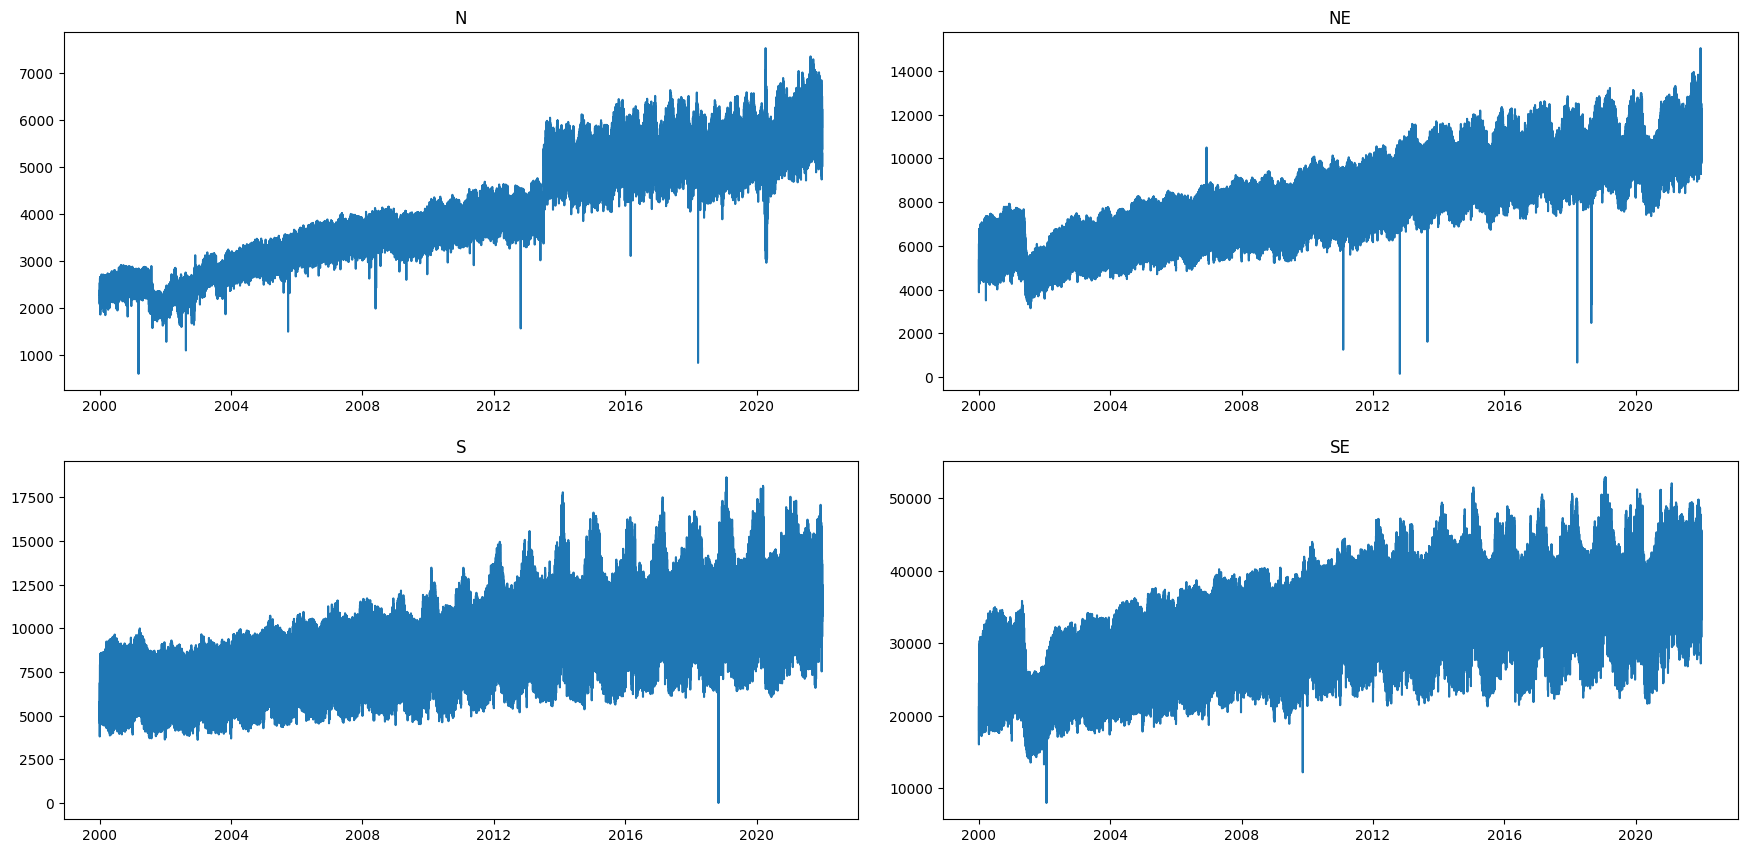

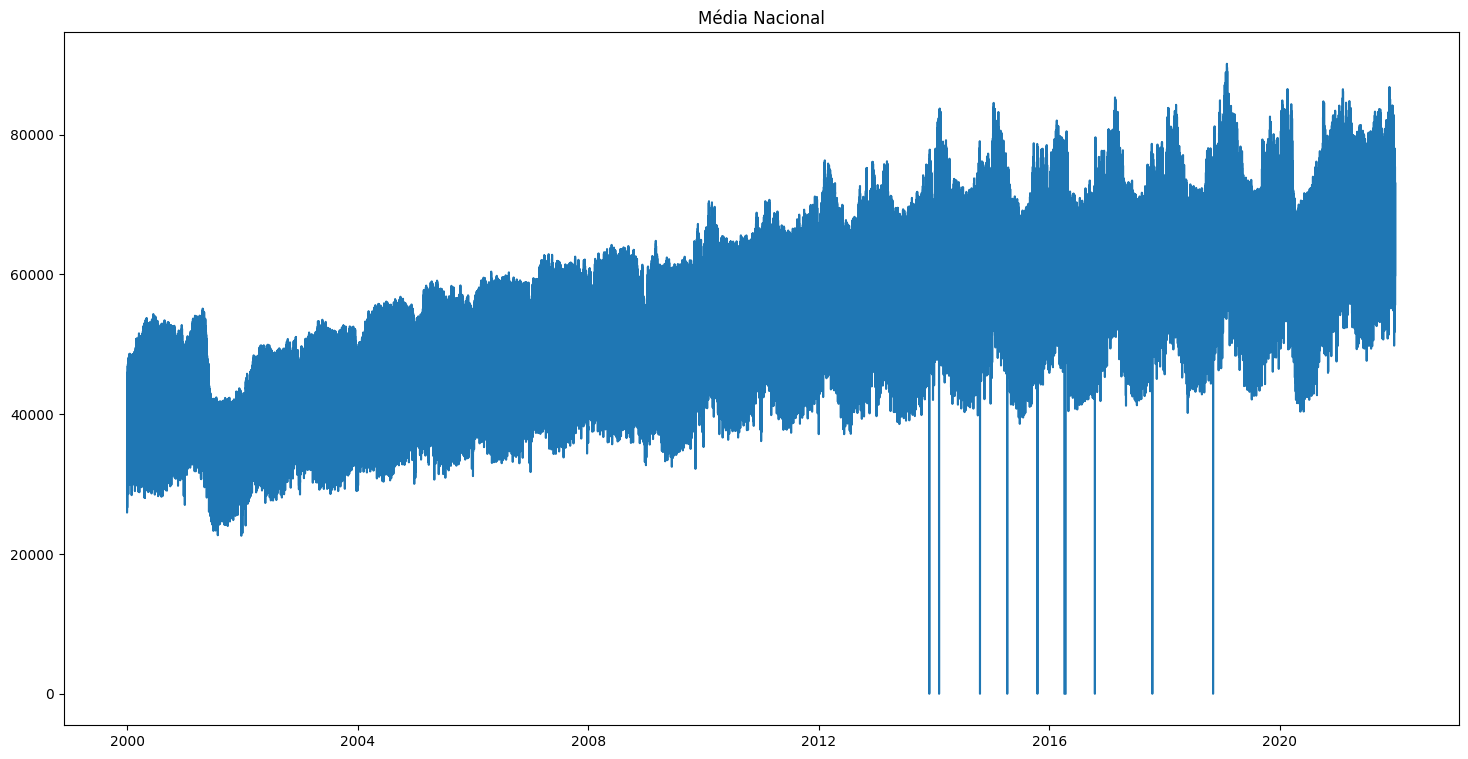

In [ ]:
#plotagem da carga nacional por região

j=0
k=0
fig, ax = plt.subplots(2,2)
fig.set_size_inches(18, 9)
fig.tight_layout(pad=3.0)
for i in carga['id_subsistema'].unique():
  ax[j,k].plot(carga['din_instante'].loc[carga['id_subsistema']==i],carga['carga'].loc[carga['id_subsistema']==i])
  ax[j,k].set_title(i)
  if k%2==0:
    k=k+1
  else:
    j=j+1
    k=0
plt.savefig('Imagens/Gráfico_1')

plt.show()


fig, ax = plt.subplots()
fig.set_size_inches(18, 9)
ax.plot(carga['carga'].groupby(carga['din_instante']).sum())
plt.title('Média Nacional')
plt.savefig('Imagens/Gráfico_2')
plt.show()




<ipython-input-10-b0b07d3bba80>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df3=carga.groupby('din_instante').sum().reset_index()
<ipython-input-10-b0b07d3bba80>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df3=df3.groupby('Ano_Mês').mean().reset_index().reset_index().rename(columns={'index':'T'})


            T         carga   M  log_carga  lcg_1st_diff
Ano_Mês                                                 
2000-01-01  0  39253.390659  01  10.577793      0.000000
2000-02-01  1  40665.397845  02  10.613133      0.035340
2000-03-01  2  40556.063720  03  10.610441     -0.002692
2000-04-01  3  40214.947917  04  10.601994     -0.008447
2000-05-01  4  40408.382258  05  10.606793      0.004798


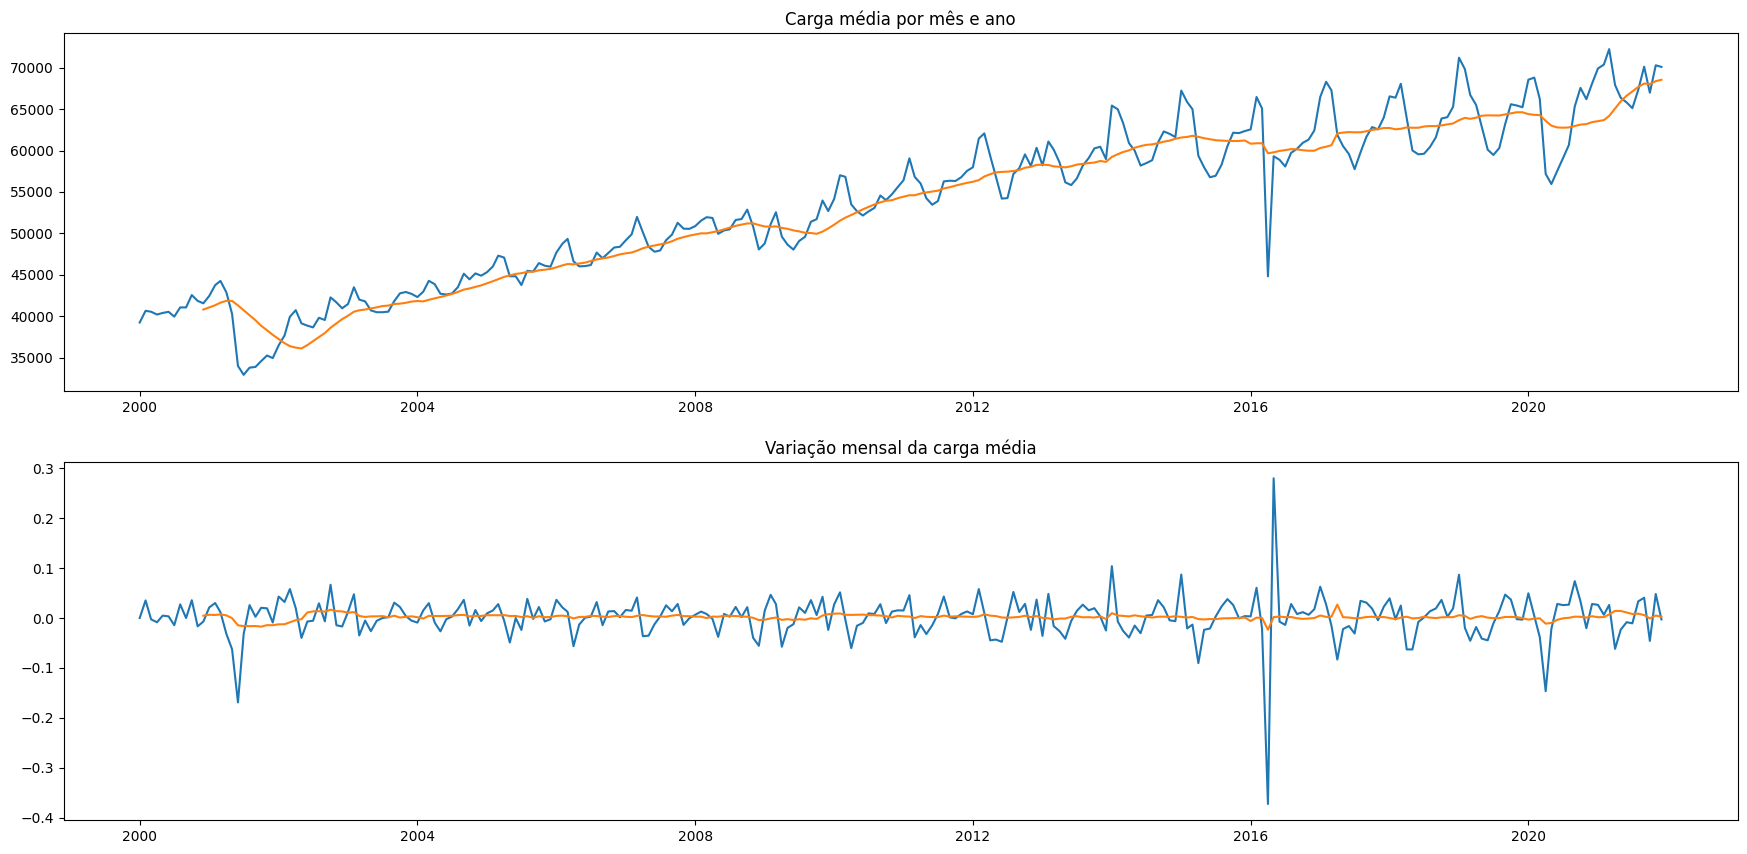

In [ ]:
#plotagem da média mensal da carga e da média móvel de 12 meses

df3=carga.groupby('din_instante').sum().reset_index()
df3['Ano_Mês']=pd.DataFrame(df3['din_instante'].apply(lambda x:str(x)[0:4]+'-'+str(x)[5:7]))
df3['Ano_Mês']=pd.to_datetime(df3['Ano_Mês'],format='%Y-%m')
df3=df3.groupby('Ano_Mês').mean().reset_index().reset_index().rename(columns={'index':'T'})
df3['M']=pd.DataFrame(df3['Ano_Mês'].apply(lambda x:str(x)[5:7]))
df3.set_index('Ano_Mês',inplace=True)

df3['log_carga']=np.log(df3['carga'])
df3['lcg_1st_diff']=df3['log_carga'].diff(periods=1).fillna(value=0)

print(df3.head())

fig, ax = plt.subplots(2,1)
fig.set_size_inches(18, 9)
fig.tight_layout(pad=3.0)
ax[0].plot(df3['carga'])
ax[0].plot(df3['carga'].dropna().rolling(12).mean())
ax[0].set_title('Carga média por mês e ano')
ax[1].plot(df3['lcg_1st_diff'])
ax[1].plot(df3['lcg_1st_diff'].dropna().rolling(12).mean())
ax[1].set_title('Variação mensal da carga média')

plt.savefig('Imagens/Gráfico_4a')
plt.show()




dfi.export(df3.head(), 'Imagens/df3.png', table_conversion='matplotlib',fontsize=12)



##Verificando Estacionariedade dos Dados

In [ ]:
#testes de estacionariedade para variáveis mensais

dfuller=pd.DataFrame()

for i in ['carga','log_carga','lcg_1st_diff']:
  dftest = adfuller(df3[i], autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  dfuller[i]=dfoutput

dfi.export(dfuller, 'Imagens/dfuller.png', table_conversion='matplotlib',fontsize=12)
dfuller





,carga,log_carga,lcg_1st_diff
Test Statistic,-0.098745,-0.540120,-5.370338
p-value,0.949563,0.883947,0.000004
#Lags Used,15.000000,16.000000,15.000000
Number of Observations Used,248.000000,247.000000,248.000000
Critical Value (1%),-3.456996,-3.457105,-3.456996
Critical Value (5%),-2.873266,-2.873314,-2.873266
Critical Value (10%),-2.573019,-2.573044,-2.573019


#Imputação de valores faltantes

In [ ]:
carga.isnull().sum()

id_subsistema       0
nom_subsistema      0
din_instante        0
carga             907
dtype: int64

In [ ]:

subsistemas=list(carga['id_subsistema'].unique())

# Define scaler to set values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Define KNN imputer and fill missing values
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

carga_imputed=pd.DataFrame()

for i in subsistemas:
  df_knn=carga.loc[carga['id_subsistema']==i].set_index('din_instante').filter(['carga']).copy()
  df_knn_scaled = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)
  df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn_scaled), columns=df_knn_scaled.columns)
  df_knn_imputed=scaler.inverse_transform(df_knn_imputed)
  df_knn_imputed=pd.Series(df_knn_imputed[:,0], index=df_knn.index)
  carga_imputed[i]=df_knn_imputed

df3=carga_imputed.reset_index().melt(id_vars='din_instante').groupby('din_instante').sum().copy().reset_index().rename(columns={'value':'carga'})

del(df_knn,df_knn_scaled,df_knn_imputed,carga_imputed)

<ipython-input-13-ec1eea70b6fa>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df3=carga_imputed.reset_index().melt(id_vars='din_instante').groupby('din_instante').sum().copy().reset_index().rename(columns={'value':'carga'})


<ipython-input-14-1c8cfee684d4>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df3=df3.groupby('Ano_Mês').mean().reset_index().reset_index().rename(columns={'index':'T'})


            T         carga   M  log_carga  lcg_1st_diff
Ano_Mês                                                 
2000-01-01  0  39253.390659  01  10.577793      0.000000
2000-02-01  1  40665.397845  02  10.613133      0.035340
2000-03-01  2  40556.063720  03  10.610441     -0.002692
2000-04-01  3  40214.947917  04  10.601994     -0.008447
2000-05-01  4  40408.382258  05  10.606793      0.004798


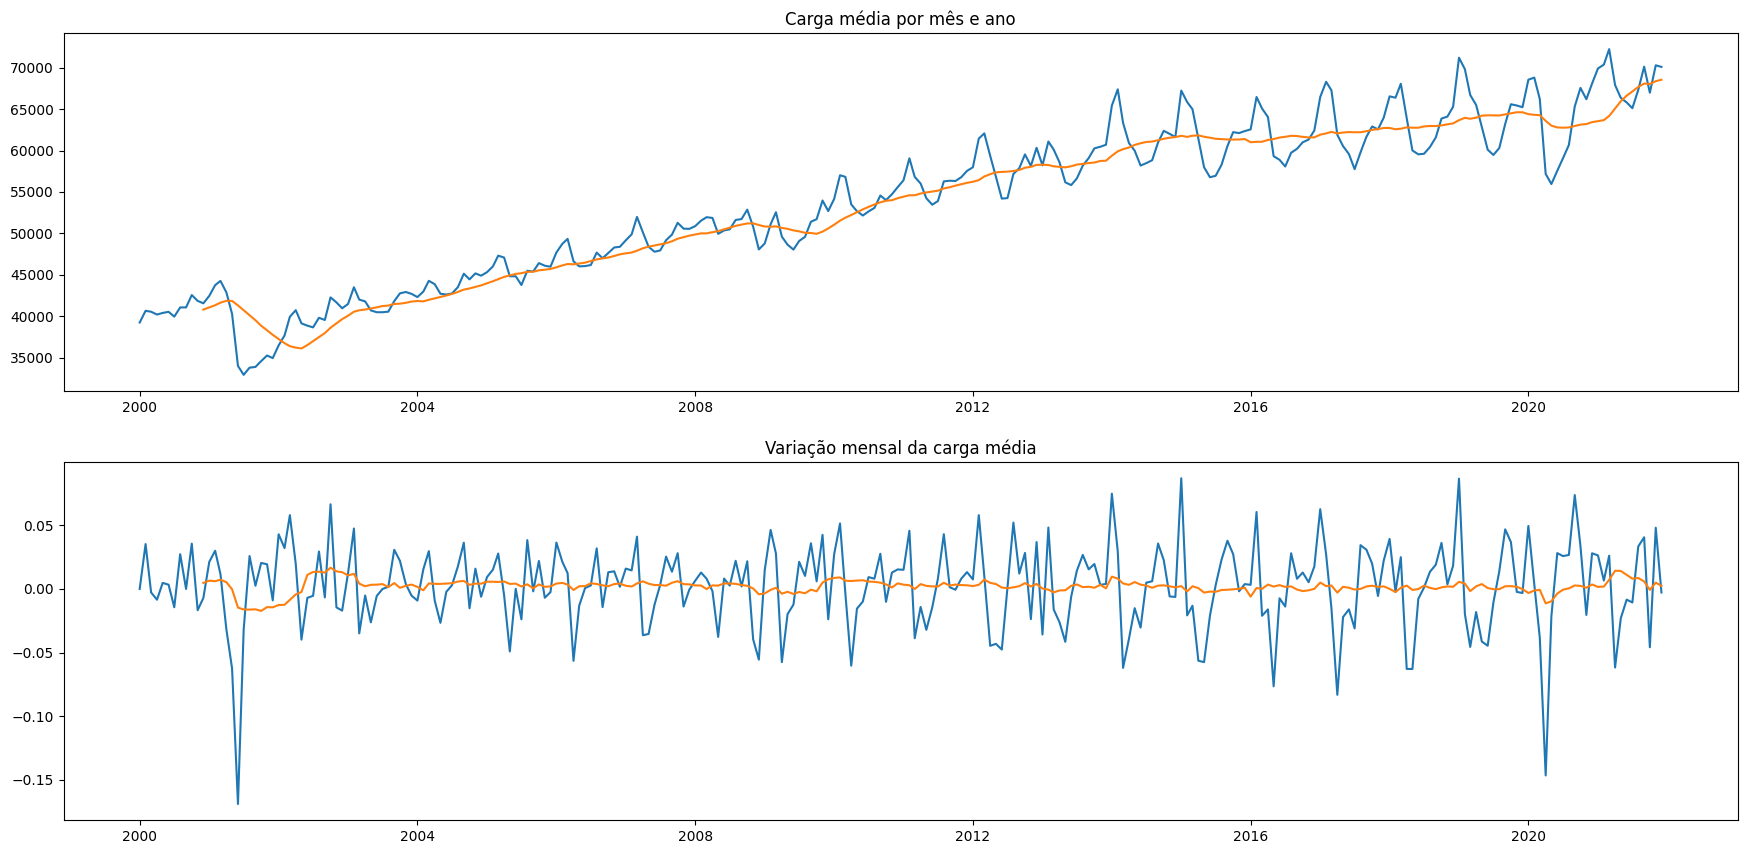

In [ ]:
#plotagem da média mensal da carga e da média móvel de 12 meses

df3['Ano_Mês']=pd.DataFrame(df3['din_instante'].apply(lambda x:str(x)[0:4]+'-'+str(x)[5:7]))
df3['Ano_Mês']=pd.to_datetime(df3['Ano_Mês'],format='%Y-%m')
df3=df3.groupby('Ano_Mês').mean().reset_index().reset_index().rename(columns={'index':'T'})
df3['M']=pd.DataFrame(df3['Ano_Mês'].apply(lambda x:str(x)[5:7]))
df3.set_index('Ano_Mês',inplace=True)



df3['log_carga']=np.log(df3['carga'])
df3['lcg_1st_diff']=df3['log_carga'].diff(periods=1).fillna(value=0)

print(df3.head())

fig, ax = plt.subplots(2,1)
fig.set_size_inches(18, 9)
fig.tight_layout(pad=3.0)
ax[0].plot(df3['carga'])
ax[0].plot(df3['carga'].dropna().rolling(12).mean())
ax[0].set_title('Carga média por mês e ano')
ax[1].plot(df3['lcg_1st_diff'])
ax[1].plot(df3['lcg_1st_diff'].dropna().rolling(12).mean())
ax[1].set_title('Variação mensal da carga média')

plt.savefig('Imagens/Gráfico_4b')
plt.show()




dfi.export(df3.head(), 'Imagens/df3.png', table_conversion='matplotlib',fontsize=12)
df3_head=df3.head()


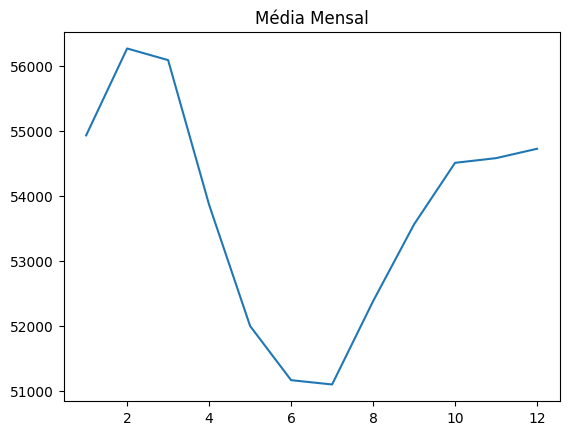

In [ ]:
#plotagem da carga nacional por mês do ano

df3.reset_index(inplace=True)
df3['Mês']=pd.DatetimeIndex(df3['Ano_Mês']).month
df3.set_index('Ano_Mês',inplace=True)
plt.plot(df3['carga'].groupby(df3['Mês']).mean())
plt.title('Média Mensal')
plt.savefig('Imagens/Gráfico_3')
plt.show()

df3.drop(['Mês'],axis=1,inplace=True)



##ACF e PACF

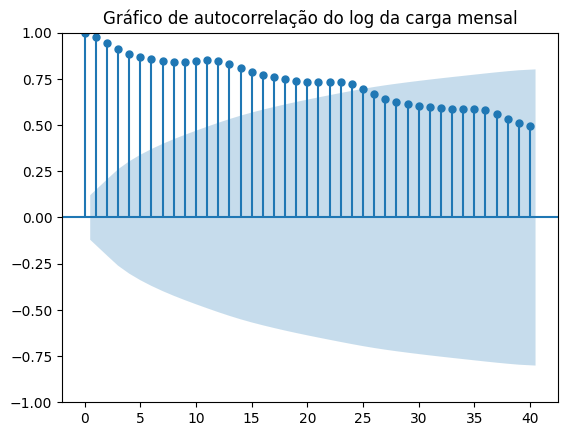

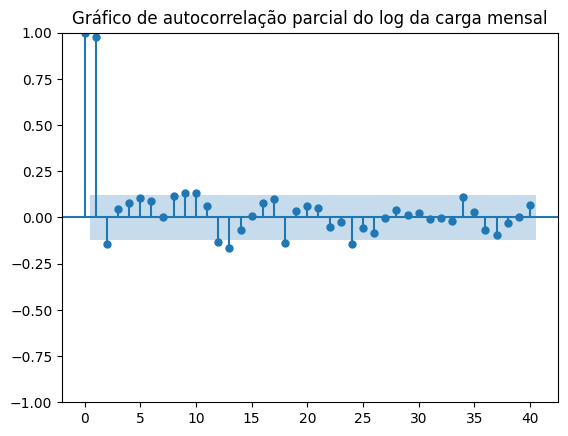

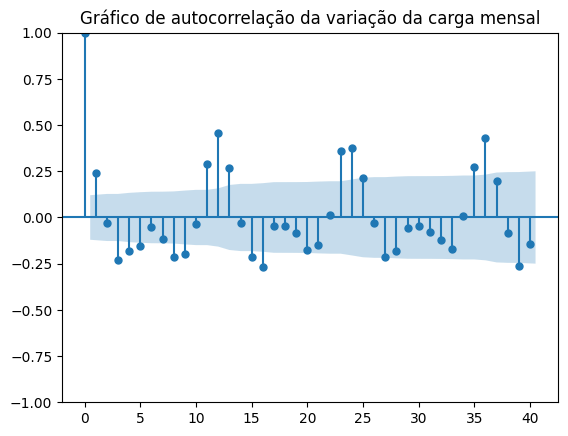

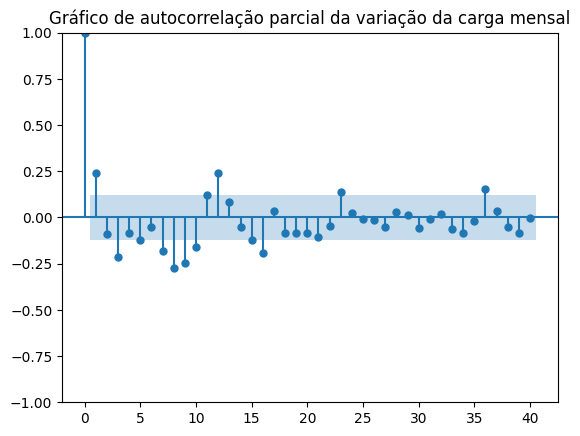

In [ ]:
sm.graphics.tsa.plot_acf(df3['log_carga'].dropna().values.squeeze(), lags=40)
plt.title('Gráfico de autocorrelação do log da carga mensal')
plt.savefig('Imagens/Gráfico_5a')
sm.graphics.tsa.plot_pacf(df3['log_carga'].dropna().values.squeeze(), lags=40, method="ywm")
plt.title('Gráfico de autocorrelação parcial do log da carga mensal')
plt.savefig('Imagens/Gráfico_5b')
sm.graphics.tsa.plot_acf(df3['lcg_1st_diff'].dropna().values.squeeze(), lags=40)
plt.title('Gráfico de autocorrelação da variação da carga mensal')
plt.savefig('Imagens/Gráfico_5c')
sm.graphics.tsa.plot_pacf(df3['lcg_1st_diff'].dropna().values.squeeze(), lags=40, method="ywm")
plt.title('Gráfico de autocorrelação parcial da variação da carga mensal')
plt.savefig('Imagens/Gráfico_5d')
plt.show()



##Verificando tendência e sazonalidade

In [ ]:
trend_reg=smf.ols(formula='log_carga~T', data=df3).fit()
print('Regressão da carga média mensal em relação ao tempo')
print(trend_reg.summary())


ts_reg=smf.ols(formula='log_carga~T+M', data=df3).fit()
print('Regressão da carga média mensal em relação ao tempo com sazonalidade')
print(ts_reg.summary())


trend_reg=smf.ols(formula='lcg_1st_diff~T', data=df3).fit()
print('Regressão da primeira diferença logarítmica mensal em relação ao tempo')
print(trend_reg.summary())


trend_reg=smf.ols(formula='lcg_1st_diff~T+M', data=df3).fit()
print('Regressão da primeira diferença logarítmica mensal em relação ao tempo com sazonalidade')
print(trend_reg.summary())


Regressão da carga média mensal em relação ao tempo
                            OLS Regression Results                            
Dep. Variable:              log_carga   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     2075.
Date:                Sat, 22 Apr 2023   Prob (F-statistic):          1.66e-126
Time:                        21:07:14   Log-Likelihood:                 362.88
No. Observations:                 264   AIC:                            -721.8
Df Residuals:                     262   BIC:                            -714.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


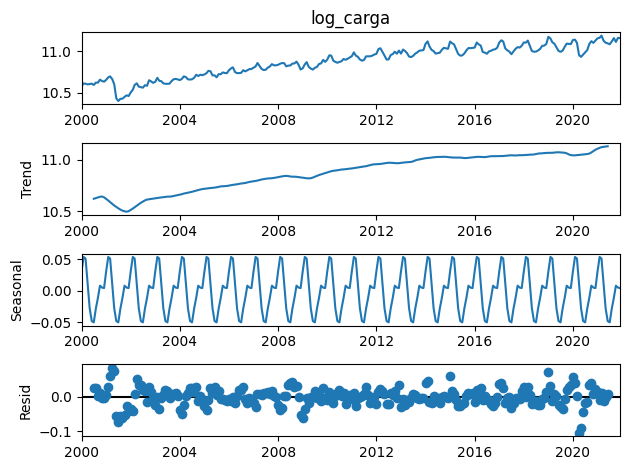

In [ ]:
#decomposição da série temporal

from random import randrange
from pandas import Series
from statsmodels.tsa.seasonal import seasonal_decompose
series = [i+randrange(10) for i in range(1,100)]
result = seasonal_decompose(df3['log_carga'], model='additive')
result.plot()
plt.savefig('Imagens/Gráfico_16')
plt.show()

#ARIMA

##Preparando os dados

In [ ]:
print(len(df3.loc['2003-01-01':]))
train_set=df3['log_carga'].loc['2003-01':'2017-12']
test_set=df3['carga'].loc['2018-01-01':]
print(len(train_set),len(train_set)/len(df3.loc['2003-01':]))
print(len(test_set),len(test_set)/len(df3.loc['2003-01':]))

228
180 0.7894736842105263
48 0.21052631578947367


##Verificando ordem do modelo

In [ ]:
#selecionando modelo ARMA com dados mensais usando pmdarima

stepwise=auto_arima(train_set,
                    start_p=0,
                    start_q=0,
                    d=1,
                    max_p=12,
                    max_q=25,
                    max_d=2,
                    seasonal=False,
                    information_criterion='bic',
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=-752.039, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=-752.789, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=-752.863, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=-755.966, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=-747.861, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.538 seconds


##Modelo ARIMA(0,1,0)

In [ ]:
# 0,1,0 ARIMA Model
model_1 = ARIMA(train_set,order=(0,1,0))
model_1_fit = model_1.fit()
print(model_1_fit.summary())


                               SARIMAX Results                                
Dep. Variable:              log_carga   No. Observations:                  180
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 380.576
Date:                Sat, 22 Apr 2023   AIC                           -759.153
Time:                        21:07:16   BIC                           -755.966
Sample:                    01-01-2003   HQIC                          -757.860
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0008   8.23e-05     10.119      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   5.87   Jarque-Bera (JB):                 2.75
Prob(Q):                              0.02   Pr

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


##usando critério aic

In [ ]:
#selecionando modelo ARMA com dados mensais usando pmdarima

stepwise=auto_arima(train_set,
                    start_p=0,
                    start_q=0,
                    d=1,
                    max_p=12,
                    max_q=25,
                    max_d=2,
                    seasonal=False,
                    information_criterion='aic',
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    with_intercept=False,
                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-759.153, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-763.420, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-763.424, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-761.656, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-763.229, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-772.583, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-786.565, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-783.812, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-784.174, Time=0.28 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=-783.802, Time=0.27 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=-785.800, Time=0.23 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=-782.576, Time=0.33 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-798.233, Time=0.37 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : 

##Modelo ARIMA(1,1,3) sem intercepto

In [ ]:
# 3,1,2 ARIMA Model
model_1 = ARIMA(train_set,order=(1,1,3))
model_1_fit = model_1.fit()
print(model_1_fit.summary())


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              log_carga   No. Observations:                  180
Model:                 ARIMA(1, 1, 3)   Log Likelihood                 398.282
Date:                Sat, 22 Apr 2023   AIC                           -786.565
Time:                        21:07:22   BIC                           -770.628
Sample:                    01-01-2003   HQIC                          -780.102
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3543      0.177      2.001      0.045       0.007       0.701
ma.L1         -0.2520      0.175     -1.438      0.150      -0.596       0.092
ma.L2         -0.1204      0.077     -1.559      0.1

In [ ]:
# Forecast
preds1 = model_1_fit.forecast(len(test_set), alpha=0.05)  # 95% conf

# Make as pandas series
preds1_series = np.exp(pd.Series(preds1, index=test_set.index))

mae = metrics.mean_absolute_error(test_set, preds1_series)
mape=metrics.mean_absolute_percentage_error(test_set, preds1_series)
mse = metrics.mean_squared_error(test_set, preds1_series)
rmse = np.sqrt(mse) # or mse**(0.5)

accu_dict={"Model":'ARIMA(1,1,3)',"MAE":mae,"MAPE":mape,"MSE":mse,"RMSE":rmse}

accu_meds1=pd.DataFrame(accu_dict.keys())
accu_meds1[1]=pd.DataFrame(accu_dict.values())
accu_meds1=accu_meds1.set_index(0).T.set_index('Model')

dfi.export(accu_meds1, 'Imagens/accu_meds1.png', table_conversion='matplotlib',fontsize=12)

accu_meds1



,MAE,MAPE,MSE,RMSE
Model,,,,
"ARIMA(1,1,3)",4042.970819,0.061384,21324223.982989,4617.815932


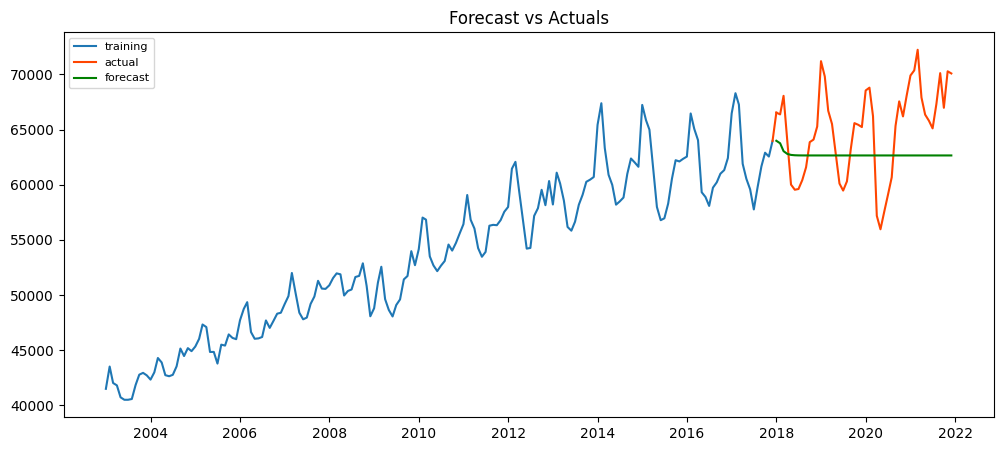

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(np.exp(train_set), label='training')
plt.plot(df3['carga'].loc['2017-12':'2018-01'],color='#FF4500')
plt.plot(test_set, label='actual',color='#FF4500')
plt.plot(preds1_series, label='forecast',color='#008000')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('Imagens/Gráfico_7')
plt.show()





##Preparando os dados

In [ ]:
print(len(df3.loc['2003-01-01':]))
train_set2=df3['log_carga'].loc['2003-01':'2017-12']
test_set2=df3['log_carga'].loc['2018-01-01':]
print(len(train_set2),len(train_set2)/len(df3.loc['2003-01':]))
print(len(test_set2),len(test_set2)/len(df3.loc['2003-01':]))

228
180 0.7894736842105263
48 0.21052631578947367


#SARIMA 

In [ ]:
#selecionando modelo SARIMA com dados mensais usando pmdarima e critério bic

stepwise=auto_arima(train_set.dropna(),
                    start_p=0,
                    start_q=0,
                    d=1,
                    max_p=12,
                    max_q=25,
                    max_d=2,
                    start_P=1,
                    start_Q=1,
                    D=1,
                    max_P=12, max_D=2, max_Q=12, 
                    m=12,
                    max_order=None,
                    seasonal=True,
                    information_criterion='bic',
                    trace=True,
                    error_action='ignore',suppress_warnings=True,
                    with_intercept=False,
                    stepwise=True)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(1,1,1)[12]             : BIC=-775.755, Time=0.49 sec
 ARIMA(0,1,0)(0,1,0)[12]             : BIC=-722.070, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : BIC=-757.152, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : BIC=-793.720, Time=0.73 sec
 ARIMA(0,1,1)(0,1,0)[12]             : BIC=-737.203, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : BIC=-788.609, Time=0.92 sec
 ARIMA(0,1,1)(0,1,2)[12]             : BIC=-788.613, Time=2.94 sec
 ARIMA(0,1,1)(1,1,0)[12]             : BIC=-762.622, Time=0.27 sec
 ARIMA(0,1,1)(1,1,2)[12]             : BIC=inf, Time=4.61 sec
 ARIMA(0,1,0)(0,1,1)[12]             : BIC=-780.362, Time=0.33 sec
 ARIMA(1,1,1)(0,1,1)[12]             : BIC=-794.941, Time=0.93 sec
 ARIMA(1,1,1)(0,1,0)[12]             : BIC=-740.798, Time=0.27 sec
 ARIMA(1,1,1)(1,1,1)[12]             : BIC=-787.178, Time=1.20 sec
 ARIMA(1,1,1)(0,1,2)[12]             : BIC=inf, Time=4.75 sec
 ARIMA(1,1,1)(1,1,0)[12]     

##SARIMA(1,1,1)(0,1,1)[12]

In [ ]:
# SARIMA Model
model2 = ARIMA(train_set,order=(1,1,1),seasonal_order=(0,1,1,12))
model2_fit = model2.fit()
print(model2_fit.summary())



/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                        log_carga   No. Observations:                  180
Model:             ARIMA(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 407.707
Date:                          Sat, 22 Apr 2023   AIC                           -807.413
Time:                                  21:07:53   BIC                           -794.941
Sample:                              01-01-2003   HQIC                          -802.351
                                   - 12-01-2017                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5154      0.097      5.309      0.000       0.325       0.706
ma.L1         -0.8670      0.065    -13.417      0.

##Verificar Acurácia do Modelo


In [ ]:
# Forecast

preds2 = model2_fit.forecast(len(test_set), alpha=0.05)  # 95% conf
#preds2 = model2_fit.forecast(48, alpha=0.05)  # 95% conf

# Make as pandas series
preds2_series = np.exp(pd.Series(preds2, index=test_set.index))

mae = metrics.mean_absolute_error(test_set, preds2_series)
mape=metrics.mean_absolute_percentage_error(test_set, preds2_series)
mse = metrics.mean_squared_error(test_set, preds2_series)
rmse = np.sqrt(mse) # or mse**(0.5)


accu_dict={"Model":'SARIMA(1,1,1)(0,1,1)[12]',"MAE":mae,"MAPE":mape,"MSE":mse,"RMSE":rmse}

accu_meds2=pd.DataFrame(accu_dict.keys())
accu_meds2[1]=pd.DataFrame(accu_dict.values())
accu_meds2=accu_meds2.set_index(0).T.set_index('Model')

dfi.export(accu_meds2, 'Imagens/accu_meds2.png', table_conversion='matplotlib',fontsize=12)

accu_meds2




,MAE,MAPE,MSE,RMSE
Model,,,,
"SARIMA(1,1,1)(0,1,1)[12]",1648.433617,0.02625,6008905.15309,2451.306826


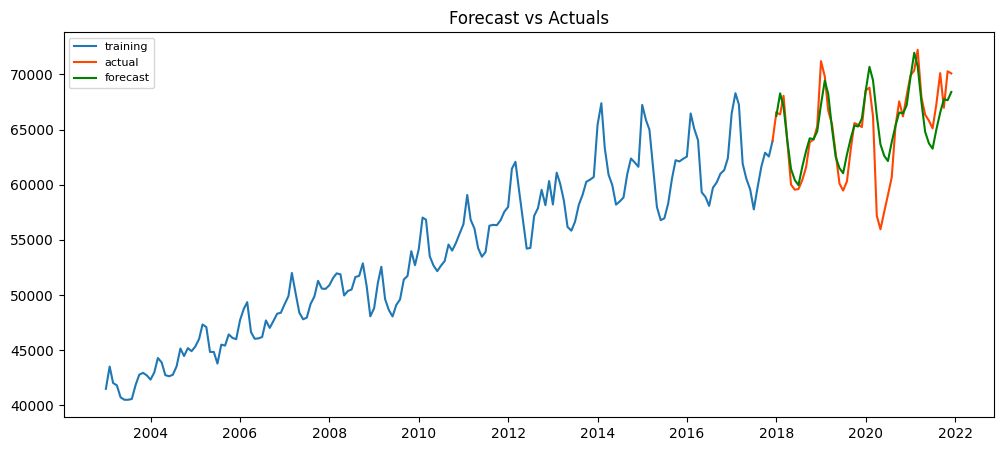

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(np.exp(train_set), label='training')
plt.plot(df3['carga'].loc['2017-12':'2018-01'],color='#FF4500')
plt.plot(test_set, label='actual',color='#FF4500')
plt.plot(preds2_series, label='forecast',color='#008000')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('Imagens/Gráfico_9')
plt.show()




#LSTM


##LSTM com duas camadas, dados em log

In [ ]:
np.random.seed(42)

tf.random.set_seed(42)

###Preparação dos Dados

In [ ]:
#criando séries com defasagem

df4=df3.copy()
df4.drop(['T','M','carga','lcg_1st_diff'],axis=1,inplace=True)

for i in range(1,13):
  df4['log_carga_t-'+str(i)]=df4['log_carga'].shift(i)

#separando conjuntos de treino e teste

print(len(df4.loc['2003-01-01':]))
train_set=df4.loc['2003-01':'2017-12']
test_set=df4.loc['2018-01':]
print(len(train_set),len(train_set)/len(df4.loc['2003-01':]))
print(len(test_set),len(test_set)/len(df4.loc['2003-01':]))

#Escalonamento

scaler=MinMaxScaler(feature_range=(0,1))

scaler = scaler.fit(train_set)
sc_train = scaler.transform(train_set)
sc_test= scaler.transform(test_set)

# Separar variáveis explicativas e os rótulos

x_variables, labels = sc_train[:, 1:], sc_train[:, 0]
x_test, y_test = sc_test[:, 1:], sc_test[:, 0]


print('Conjuntos de treino tem o mesmo comprimento?', len(x_variables)==len(labels))



228
180 0.7894736842105263
48 0.21052631578947367
Conjuntos de treino tem o mesmo comprimento? True


###criando e treinando a rede neural

In [ ]:
lstm_model = keras.Sequential(
    [
    keras.layers.LSTM(units=20, input_shape=(None,1), activation="tanh", return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(units=20, activation="tanh", return_sequences=False),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=1, activation="linear")
    ]
)

lstm_model.compile(loss="mse", optimizer="adam", metrics=[tf.keras.metrics.RootMeanSquaredError()])

lstm_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 20)          1760      
                                                                 
 dropout (Dropout)           (None, None, 20)          0         
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_history = lstm_model.fit(
    x_variables, 
    labels, 
    epochs=20)#,callbacks=[keras.callbacks.EarlyStopping(monitor='root_mean_squared_error', min_delta=0.1, patience=10, restore_best_weights=True)])

Epoch 1/20
6/6 [==============================] - 5s 15ms/step - loss: 0.3175 - root_mean_squared_error: 0.5634
Epoch 2/20
6/6 [==============================] - 0s 12ms/step - loss: 0.2270 - root_mean_squared_error: 0.4765
Epoch 3/20
6/6 [==============================] - 0s 12ms/step - loss: 0.1417 - root_mean_squared_error: 0.3765
Epoch 4/20
6/6 [==============================] - 0s 12ms/step - loss: 0.0595 - root_mean_squared_error: 0.2439
Epoch 5/20
6/6 [==============================] - 0s 12ms/step - loss: 0.0293 - root_mean_squared_error: 0.1711
Epoch 6/20
6/6 [==============================] - 0s 12ms/step - loss: 0.0365 - root_mean_squared_error: 0.1911
Epoch 7/20
6/6 [==============================] - 0s 12ms/step - loss: 0.0295 - root_mean_squared_error: 0.1718
Epoch 8/20
6/6 [==============================] - 0s 12ms/step - loss: 0.0209 - root_mean_squared_error: 0.1446
Epoch 9/20
6/6 [==============================] - 0s 12ms/step - loss: 0.0201 - root_mean_squared_error:

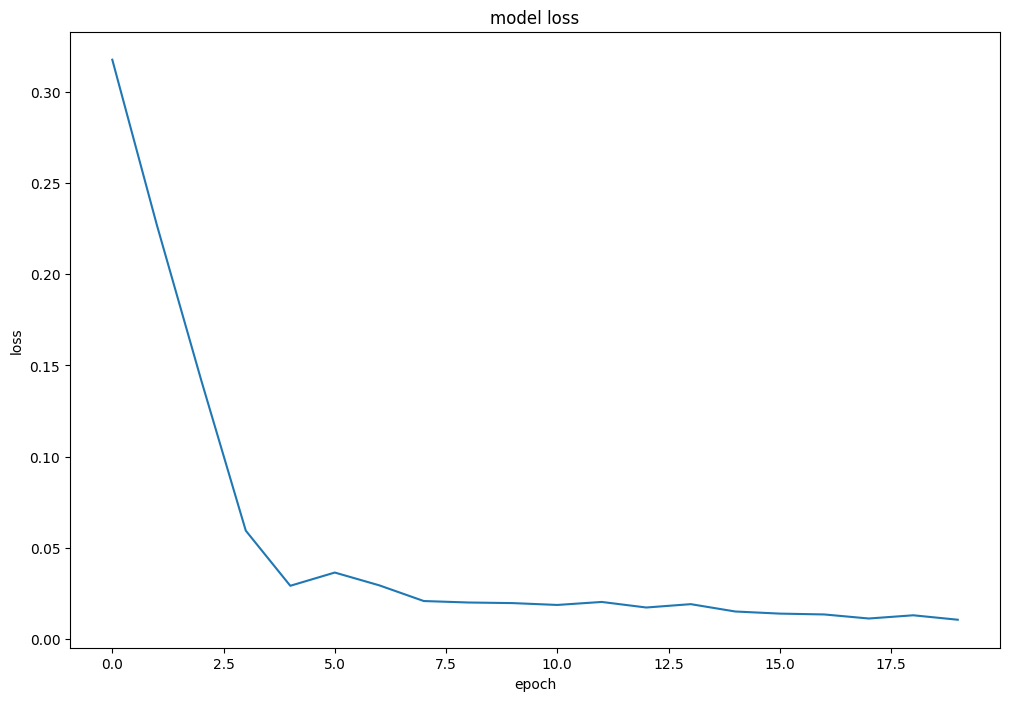

In [ ]:
# summarize history for loss
plt.figure(figsize=(12,8))
plt.plot(lstm_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig('Imagens/Gráfico_14a')
plt.show()

##Verificar Acurácia do Modelo

In [ ]:
# In-sample Forecast
preds3 = lstm_model.predict(x_test)

df_pred=pd.DataFrame(preds3)
x_test_df=pd.DataFrame(x_test)
df_pred=pd.merge(df_pred,x_test_df,left_index=True,right_index=True)
array_pred=np.array(df_pred)
preds3 = scaler.inverse_transform(array_pred)

# Make as pandas series
preds3_series = np.exp(pd.Series(preds3[:,0], index=test_set.index))



mae = metrics.mean_absolute_error(np.exp(test_set['log_carga']), preds3_series)
mape=metrics.mean_absolute_percentage_error(np.exp(test_set['log_carga']), preds3_series)
mse = metrics.mean_squared_error(np.exp(test_set['log_carga']), preds3_series)
rmse = np.sqrt(mse) # or mse**(0.5)

accu_dict={"Model":'LSTM',"MAE":mae,"MAPE":mape,"MSE":mse,"RMSE":rmse}

accu_meds3=pd.DataFrame(accu_dict.keys())
accu_meds3[1]=pd.DataFrame(accu_dict.values())
accu_meds3=accu_meds3.set_index(0).T.set_index('Model')

dfi.export(accu_meds3, 'Imagens/accu_meds3.png', table_conversion='matplotlib',fontsize=12)

accu_meds3



2/2 [==============================] - 1s 6ms/step


,MAE,MAPE,MSE,RMSE
Model,,,,
LSTM,3959.524731,0.060166,22140614.044052,4705.381392


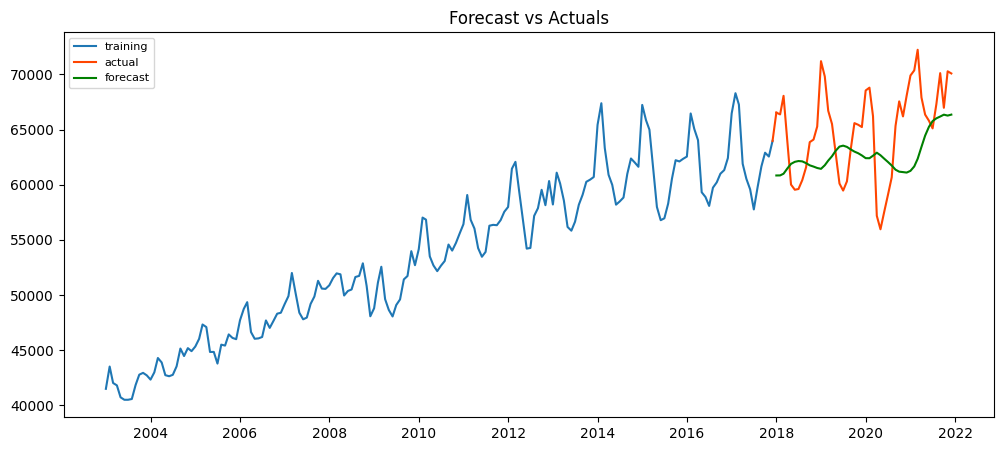

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(np.exp(train_set['log_carga']), label='training')
plt.plot(df3['carga'].loc['2017-12':'2018-01'],color='#FF4500')
plt.plot(np.exp(test_set['log_carga']), label='actual',color='#FF4500')
plt.plot(preds3_series, label='forecast',color='#008000')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('Imagens/Gráfico_14b')
plt.show()



In [ ]:
# Out-of-sample Forecast
x_testf=x_test.copy()
preds3f=np.ndarray(shape=(len(x_testf),1))
t_array=np.ndarray(12)
for i in range(len(x_testf)):
  preds3f[i] = lstm_model.predict(x_testf[i:i+1])
  t_array[0]=preds3f[i]
  t_array[1:12]=x_testf[i][0:11]
  if i<len(x_testf)-1:
    x_testf[i+1]=t_array

del(x_testf,t_array)

df_pred=pd.DataFrame(preds3f)
x_test_df=pd.DataFrame(x_test)
df_pred=pd.merge(df_pred,x_test_df,left_index=True,right_index=True)
array_pred=np.array(df_pred)
preds3f = scaler.inverse_transform(array_pred)

# Make as pandas series
preds3f_series = np.exp(pd.Series(preds3f[:,0], index=test_set.index))



mae = metrics.mean_absolute_error(np.exp(test_set['log_carga']), preds3f_series)
mape=metrics.mean_absolute_percentage_error(np.exp(test_set['log_carga']), preds3f_series)
mse = metrics.mean_squared_error(np.exp(test_set['log_carga']), preds3f_series)
rmse = np.sqrt(mse) # or mse**(0.5)

accu_dict={"Model":'LSTM_f',"MAE":mae,"MAPE":mape,"MSE":mse,"RMSE":rmse}

accu_meds3f=pd.DataFrame(accu_dict.keys())
accu_meds3f[1]=pd.DataFrame(accu_dict.values())
accu_meds3f=accu_meds3f.set_index(0).T.set_index('Model')

dfi.export(accu_meds3f, 'Imagens/accu_meds3f.png', table_conversion='matplotlib',fontsize=12)

accu_meds3f



1/1 [==============================] - 0s 31ms/step


,MAE,MAPE,MSE,RMSE
Model,,,,
LSTM_f,9167.018859,0.136747,116408605.818257,10789.281988


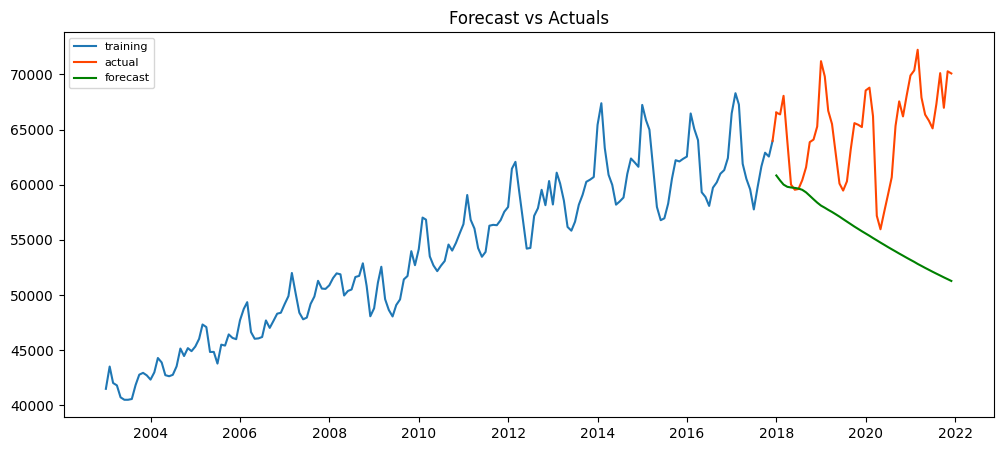

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(np.exp(train_set['log_carga']), label='training')
plt.plot(df3['carga'].loc['2017-12':'2018-01'],color='#FF4500')
plt.plot(np.exp(test_set['log_carga']), label='actual',color='#FF4500')
plt.plot(preds3f_series, label='forecast',color='#008000')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('Imagens/Gráfico_14c')
plt.show()



##LSTM com duas camadas, dados em diferenças

In [ ]:
np.random.seed(42)

tf.random.set_seed(42)

###Preparação dos Dados (Aplicar diferenças)


In [ ]:
#separar conjunto de treino e de teste

df4=df3.copy()
df4.drop(['T','M','log_carga','lcg_1st_diff'],axis=1,inplace=True)

for i in range(1,13):
  df4['carga_t-'+str(i)]=df4['carga'].shift(i)

print(len(df4.loc['2003-01':]))
train_set=df4.loc['2002-12':'2017-12'].copy()
test_set=df4.loc['2017-12':].copy()

#gerando valores em diferenças percentuais

train_set2=train_set.copy()

colunas=train_set2.columns
for i in range(len(colunas)):
  train_set2[colunas[i]]=np.log(train_set2[colunas[i]])
  train_set2[colunas[i]]=train_set2[colunas[i]].diff(periods=1).fillna(value=0)

test_set2=test_set.copy()
colunas=test_set2.columns
for i in range(len(colunas)):
  test_set2[colunas[i]]=np.log(test_set2[colunas[i]])
  test_set2[colunas[i]]=test_set2[colunas[i]].diff(periods=1).fillna(value=0)

train_set.drop(['2002-12'],axis=0,inplace=True)
test_set.drop(['2017-12'],axis=0,inplace=True)
train_set2.drop(['2002-12'],axis=0,inplace=True)
test_set2.drop(['2017-12'],axis=0,inplace=True)

print(len(train_set2),len(train_set)/len(df4.loc['2002-12':]))
print(len(test_set2),len(test_set2)/len(df4.loc['2002-12':]))

#Escalonamento

from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))

scaler = scaler.fit(train_set2)
sc_train = scaler.transform(train_set2)
sc_test= scaler.transform(test_set2)
del(train_set2, test_set2)

# Separar variáveis explicativas e os rótulos

x_variables, labels = sc_train[:, 1:], sc_train[:, 0]
x_test, y_test = sc_test[:, 1:], sc_test[:, 0]


print('Conjuntos de treino tem o mesmo comprimento?', len(x_variables)==len(labels))



228
180 0.7860262008733624
48 0.2096069868995633
Conjuntos de treino tem o mesmo comprimento? True


###criando e treinando a rede neural

In [ ]:
lstm_model_2 = keras.Sequential(
    [
    keras.layers.LSTM(units=20, input_shape=(None,1), activation="tanh", return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(units=20, activation="tanh", return_sequences=False),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=1, activation="linear")
    ]
)

lstm_model_2.compile(loss="mse", optimizer="adam", metrics=[tf.keras.metrics.RootMeanSquaredError()])

lstm_model_2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 20)          1760      
                                                                 
 dropout_2 (Dropout)         (None, None, 20)          0         
                                                                 
 lstm_3 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm2_history = lstm_model_2.fit(
    x_variables, 
    labels, 
    epochs=20)#,callbacks=[keras.callbacks.EarlyStopping(monitor='root_mean_squared_error', min_delta=0.1, patience=10, restore_best_weights=True)])

Epoch 1/20
6/6 [==============================] - 4s 15ms/step - loss: 0.2077 - root_mean_squared_error: 0.4558
Epoch 2/20
6/6 [==============================] - 0s 12ms/step - loss: 0.1174 - root_mean_squared_error: 0.3426
Epoch 3/20
6/6 [==============================] - 0s 12ms/step - loss: 0.0496 - root_mean_squared_error: 0.2226
Epoch 4/20
6/6 [==============================] - 0s 13ms/step - loss: 0.0457 - root_mean_squared_error: 0.2138
Epoch 5/20
6/6 [==============================] - 0s 12ms/step - loss: 0.0452 - root_mean_squared_error: 0.2127
Epoch 6/20
6/6 [==============================] - 0s 13ms/step - loss: 0.0349 - root_mean_squared_error: 0.1868
Epoch 7/20
6/6 [==============================] - 0s 12ms/step - loss: 0.0376 - root_mean_squared_error: 0.1939
Epoch 8/20
6/6 [==============================] - 0s 12ms/step - loss: 0.0380 - root_mean_squared_error: 0.1948
Epoch 9/20
6/6 [==============================] - 0s 12ms/step - loss: 0.0353 - root_mean_squared_error:

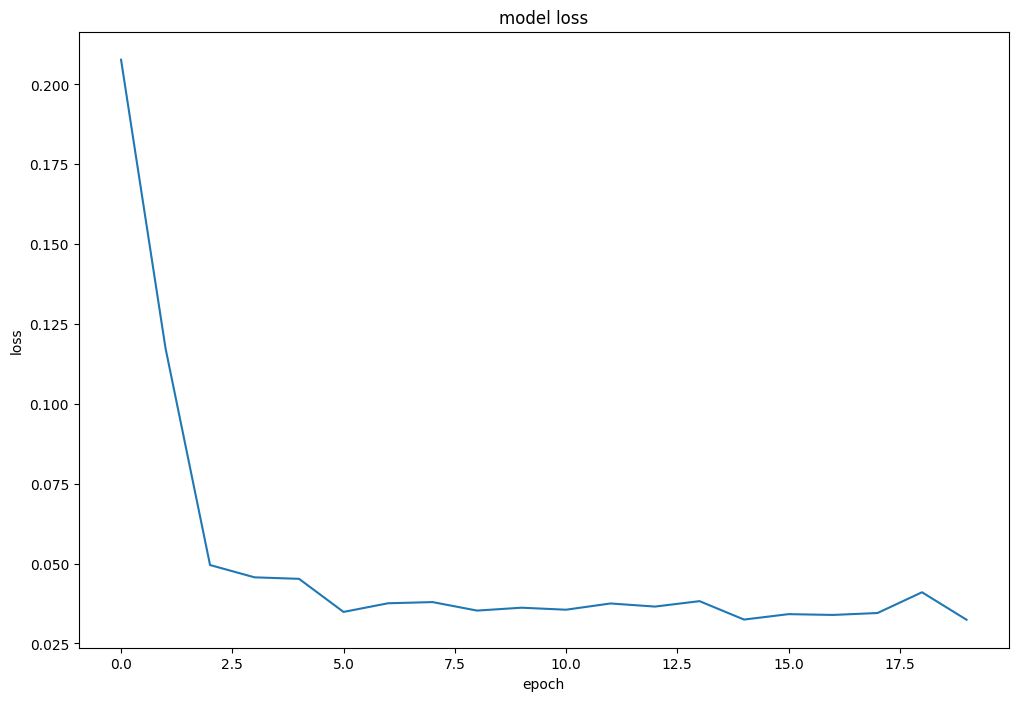

In [ ]:
# summarize history for loss
plt.figure(figsize=(12,8))
plt.plot(lstm2_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig('Imagens/Gráfico_15a')
plt.show()

##Verificar Acurácia do Modelo

In [ ]:
#One step Forecast
preds4 = lstm_model_2.predict(x_test)

df_pred=pd.DataFrame(preds4)
x_test_df=pd.DataFrame(x_test)
df_pred=pd.merge(df_pred,x_test_df,left_index=True,right_index=True)
array_pred=np.array(df_pred)

#desescalonar
preds4 = scaler.inverse_transform(array_pred)

# Make as pandas series
preds4_series = pd.Series(preds4[:,0], index=test_set.index)

#retornar para valores de linha

preds4_series=preds4_series.cumsum()
log_carga_inic=df4['carga'].loc['2017-12']
log_carga_inic=log_carga_inic.reset_index()['carga']
preds4_series=preds4_series.apply(lambda x:x+np.log(log_carga_inic))
preds4_series=np.exp(preds4_series)


mae = metrics.mean_absolute_error(test_set['carga'], preds4_series)
mape=metrics.mean_absolute_percentage_error(test_set['carga'], preds4_series)
mse = metrics.mean_squared_error(test_set['carga'], preds4_series)
rmse = np.sqrt(mse) # or mse**(0.5)

accu_dict={"Model":'LSTM2',"MAE":mae,"MAPE":mape,"MSE":mse,"RMSE":rmse}

accu_meds4=pd.DataFrame(accu_dict.keys())
accu_meds4[1]=pd.DataFrame(accu_dict.values())
accu_meds4=accu_meds4.set_index(0).T.set_index('Model')

dfi.export(accu_meds4, 'Imagens/accu_meds4.png', table_conversion='matplotlib',fontsize=12)

accu_meds4


2/2 [==============================] - 1s 6ms/step


,MAE,MAPE,MSE,RMSE
Model,,,,
LSTM2,5782.450733,0.086189,49250453.313322,7017.866721


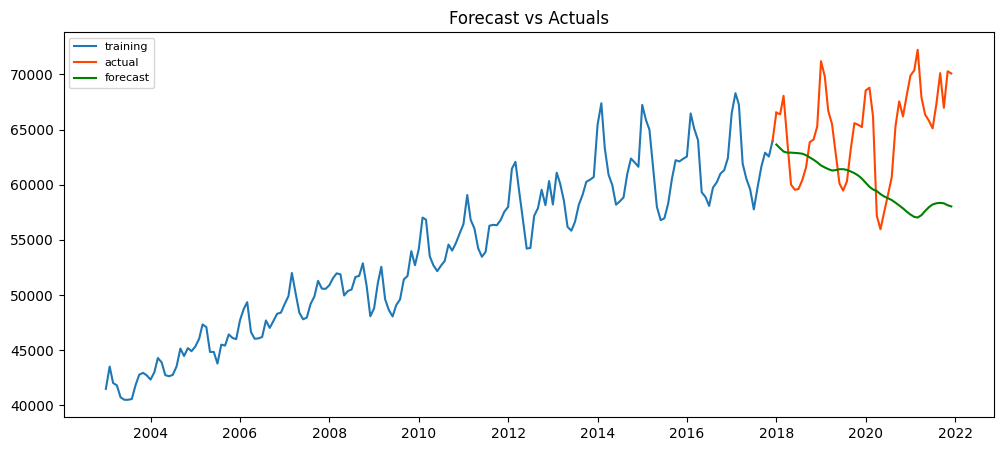

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_set['carga'], label='training')
plt.plot(df3['carga'].loc['2017-12':'2018-01'],color='#FF4500')
plt.plot(test_set['carga'], label='actual',color='#FF4500')
plt.plot(preds4_series, label='forecast',color='#008000')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('Imagens/Gráfico_15b')
plt.show()



In [ ]:
#  Forecast com dados gerados pelo modelo
x_testf=x_test.copy()
preds4f=np.ndarray(shape=(len(x_testf),1))
t_array=np.ndarray(12)
for i in range(len(x_testf)):
  preds4f[i] = lstm_model.predict(x_testf[i:i+1])
  t_array[0]=preds4f[i]
  t_array[1:12]=x_testf[i][0:11]
  if i<len(x_testf)-1:
    x_testf[i+1]=t_array

del(x_testf)

df_pred=pd.DataFrame(preds4f)
x_test_df=pd.DataFrame(x_test)
df_pred=pd.merge(df_pred,x_test_df,left_index=True,right_index=True)
array_pred=np.array(df_pred)

#desescalonar
preds4f = scaler.inverse_transform(array_pred)

# Make as pandas series
preds4f_series = pd.Series(preds4f[:,0], index=test_set.index)

#retornar para valores de linha

preds4f_series=preds4f_series.cumsum()
preds4f_series=preds4f_series.apply(lambda x:x+np.log(df4['carga'].loc['2017-12']))
preds4f_series=np.exp(preds4f_series)


mae = metrics.mean_absolute_error(test_set['carga'], preds4f_series)
mape=metrics.mean_absolute_percentage_error(test_set['carga'], preds4f_series)
mse = metrics.mean_squared_error(test_set['carga'], preds4f_series)
rmse = np.sqrt(mse) # or mse**(0.5)

accu_dict={"Model":'LSTM2_f',"MAE":mae,"MAPE":mape,"MSE":mse,"RMSE":rmse}

accu_meds4f=pd.DataFrame(accu_dict.keys())
accu_meds4f[1]=pd.DataFrame(accu_dict.values())
accu_meds4f=accu_meds4f.set_index(0).T.set_index('Model')

dfi.export(accu_meds4f, 'Imagens/accu_meds4f.png', table_conversion='matplotlib',fontsize=12)

accu_meds4f


1/1 [==============================] - 0s 27ms/step


,MAE,MAPE,MSE,RMSE
Model,,,,
LSTM2_f,19637.551913,0.295245,594288382.935696,24378.030744


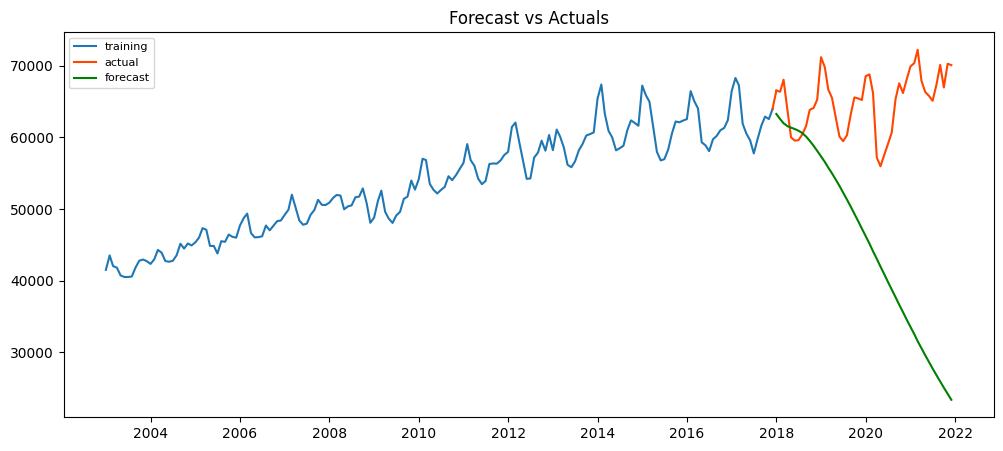

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_set['carga'], label='training')
plt.plot(df3['carga'].loc['2017-12':'2018-01'],color='#FF4500')
plt.plot(test_set['carga'], label='actual',color='#FF4500')
plt.plot(preds4f_series, label='forecast',color='#008000')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('Imagens/Gráfico_15c')
plt.show()



#PIB a preços constantes

In [ ]:
gdp=pd.read_csv("Dados/Macroeconomicas/ipeadata[10-07-2022-07-51].csv",sep=';',decimal=',')
gdp.rename(columns={'PIB - R$ - Banco Central do Brasil, Boletim, Seção Atividade Econômica (Bacen / Boletim / Ativ. Ec.) - BM12_PIB12':'PIB'},inplace=True)
gdp.drop(gdp.columns[gdp.columns.str.contains('unnamed',case=False)],axis=1,inplace=True)
inpc=pd.read_csv("Dados/Macroeconomicas/ipeadata[18-07-2022-08-26].csv",sep=';',decimal=',')
inpc.rename(columns={'INPC - geral - índice (dez. 1993 = 100) - - - Instituto Brasileiro de Geografia e Estatística, Sistema Nacional de Índices de Preços ao Consumidor (IBGE/SNIPC) - PRECOS12_INPC12':'INPC'},inplace=True)
inpc.drop(inpc.columns[inpc.columns.str.contains('unnamed',case=False)],axis=1,inplace=True)
gdp=gdp.merge(inpc,left_on='Data',right_on='Data')
gdp['PIB_pc']=gdp['PIB']/gdp['INPC']*100
del(inpc)
gdp['Data']=pd.to_datetime(gdp['Data'],format='%Y-%m')
gdp.set_index('Data',inplace=True)
gdp=gdp.loc['2000-01-01':]
dfi.export(gdp.head(), 'Imagens/gdp.png', table_conversion='matplotlib',fontsize=12)
gdp_head=gdp.head()
gdp

,PIB,INPC,PIB_pc
Data,,,
2000-01-01,92576.6,1598.24,5792.409150
2000-02-01,91770.4,1599.04,5739.093456
2000-03-01,92579.9,1601.12,5782.196213
2000-04-01,91376.2,1602.56,5701.889477
2000-05-01,98727.0,1601.76,6163.657477
...,...,...,...
2022-01-01,703751.9,6373.00,11042.709870
2022-02-01,728663.6,6436.73,11320.400265
2022-03-01,816809.8,6546.80,12476.474003


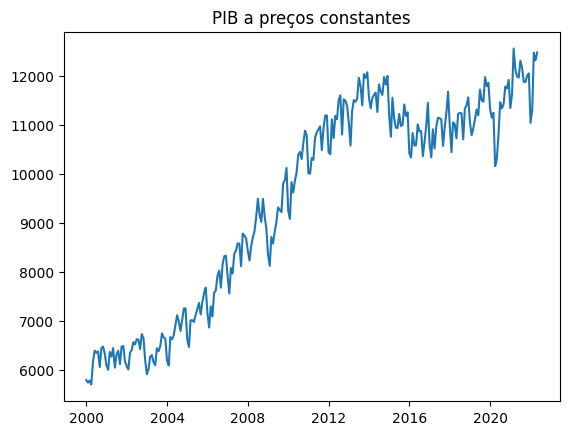

In [ ]:
plt.plot(gdp['PIB_pc'])
plt.title('PIB a preços constantes')
plt.savefig('Imagens/Gráfico_10')
plt.show()


In [ ]:
gdp['log_PIBc']=np.log(gdp['PIB_pc'])
gdp['lPIBc_1diff']=gdp['log_PIBc'].diff(periods=1).fillna(value=0)
dfi.export(gdp.head(), 'Imagens/gdp2.png', table_conversion='matplotlib',fontsize=12)
gdp_head2=gdp.head()
gdp.head()

,PIB,INPC,PIB_pc,log_PIBc,lPIBc_1diff
Data,,,,,
2000-01-01,92576.6,1598.24,5792.409150,8.664304,0.000000
2000-02-01,91770.4,1599.04,5739.093456,8.655057,-0.009247
2000-03-01,92579.9,1601.12,5782.196213,8.662539,0.007482
2000-04-01,91376.2,1602.56,5701.889477,8.648553,-0.013986
2000-05-01,98727.0,1601.76,6163.657477,8.726426,0.077873


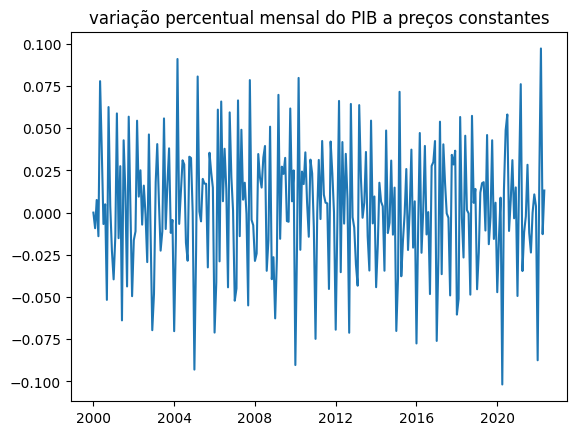

In [ ]:
plt.plot(gdp['lPIBc_1diff'])
plt.title('variação percentual mensal do PIB a preços constantes')
plt.savefig('Imagens/Gráfico_11')
plt.show()


##fazer teste de estacionaridade

In [ ]:
#testes de estacionariedade para variáveis mensais

dfuller_gdp=pd.DataFrame()

for i in ['PIB_pc', 'log_PIBc', 'lPIBc_1diff']:
  dftest = adfuller(gdp[i], autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  dfuller_gdp[i]=dfoutput

dfi.export(dfuller_gdp, 'Imagens/dfuller_gdp.png', table_conversion='matplotlib',fontsize=12)
dfuller_gdp

,PIB_pc,log_PIBc,lPIBc_1diff
Test Statistic,-1.009462,-1.432046,-4.923263
p-value,0.749798,0.566820,0.000031
#Lags Used,12.000000,12.000000,11.000000
Number of Observations Used,256.000000,256.000000,257.000000
Critical Value (1%),-3.456155,-3.456155,-3.456054
Critical Value (5%),-2.872897,-2.872897,-2.872853
Critical Value (10%),-2.572822,-2.572822,-2.572799


##Verificando tendência e sazonalidade

In [ ]:
gdp=gdp.reset_index().reset_index().rename(columns={'index':'T'})
gdp['M']=pd.DataFrame(gdp['Data'].apply(lambda x:str(x)[5:7]))
gdp.set_index('Data',inplace=True)

trend_reg=smf.ols(formula='PIB_pc~T+M', data=gdp).fit()
print('Regressão do PIB mensal em relação ao tempo com sazonalidade')
print(trend_reg.summary())


trend_reg=smf.ols(formula='lPIBc_1diff~T+M', data=gdp).fit()
print('Regressão da primeira diferença logarítmica mensal em relação ao tempo')
print(trend_reg.summary())

gdp.drop(columns={ 'T','M'},inplace=True)


Regressão do PIB mensal em relação ao tempo com sazonalidade
                            OLS Regression Results                            
Dep. Variable:                 PIB_pc   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     146.9
Date:                Sat, 22 Apr 2023   Prob (F-statistic):          2.61e-107
Time:                        21:08:26   Log-Likelihood:                -2162.8
No. Observations:                 269   AIC:                             4352.
Df Residuals:                     256   BIC:                             4398.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

#Dados Meteorológicos 

In [ ]:
met_data=pd.read_csv("Dados/tempo_consolidado.csv")
met_data['Data Medicao']=pd.to_datetime(met_data['Data Medicao'],format='%Y-%m-%d')
met_data.rename(columns={'PRECIPITACAO TOTAL, HORARIO(mm)':'PRECIPITACAO', 'RADIACAO GLOBAL(Kj/m²)':'RAD_GLOBAL',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)':'TEMP_AR',
       'VENTO, VELOCIDADE HORARIA(m/s)':'VELOC_VENTO'}, inplace=True)

dfi.export(met_data.head(), 'Imagens/met_data.png', table_conversion='matplotlib',fontsize=12)
met_data_head=met_data.head()
met_data.head()

,Data Medicao,REGIAO,PRECIPITACAO,RAD_GLOBAL,TEMP_AR,VELOC_VENTO
0,2000-05-06,CO,NaN,NaN,NaN,NaN
1,2000-05-07,CO,0.0,1566.000000,25.125000,1.766667
2,2000-05-08,CO,0.0,889.916667,22.104167,2.066667
3,2000-05-08,N,NaN,NaN,NaN,NaN
4,2000-05-09,CO,0.0,721.333333,22.041667,1.150000


In [ ]:
met_data['Ano_Mês']=pd.DataFrame(met_data['Data Medicao'].apply(lambda x:str(x)[0:4]+'-'+str(x)[5:7]))
met_data['Ano_Mês']=pd.to_datetime(met_data['Ano_Mês'],format='%Y-%m')
met_data= met_data.groupby('Ano_Mês').mean()


dfi.export(met_data.head(), 'Imagens/met_data2.png', table_conversion='matplotlib',fontsize=12)
met_data_head2=met_data.head()
met_data.head()


<ipython-input-58-0d55f7956fab>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  met_data= met_data.groupby('Ano_Mês').mean()


,PRECIPITACAO,RAD_GLOBAL,TEMP_AR,VELOC_VENTO
Ano_Mês,,,,
2000-05-01,0.043618,708.817298,22.749734,1.569517
2000-06-01,0.023426,699.272548,22.539826,1.909051
2000-07-01,0.082616,638.134525,21.511641,2.058742
2000-08-01,0.070787,741.659644,23.138155,2.077949
2000-09-01,0.164844,775.839620,22.891764,2.165117


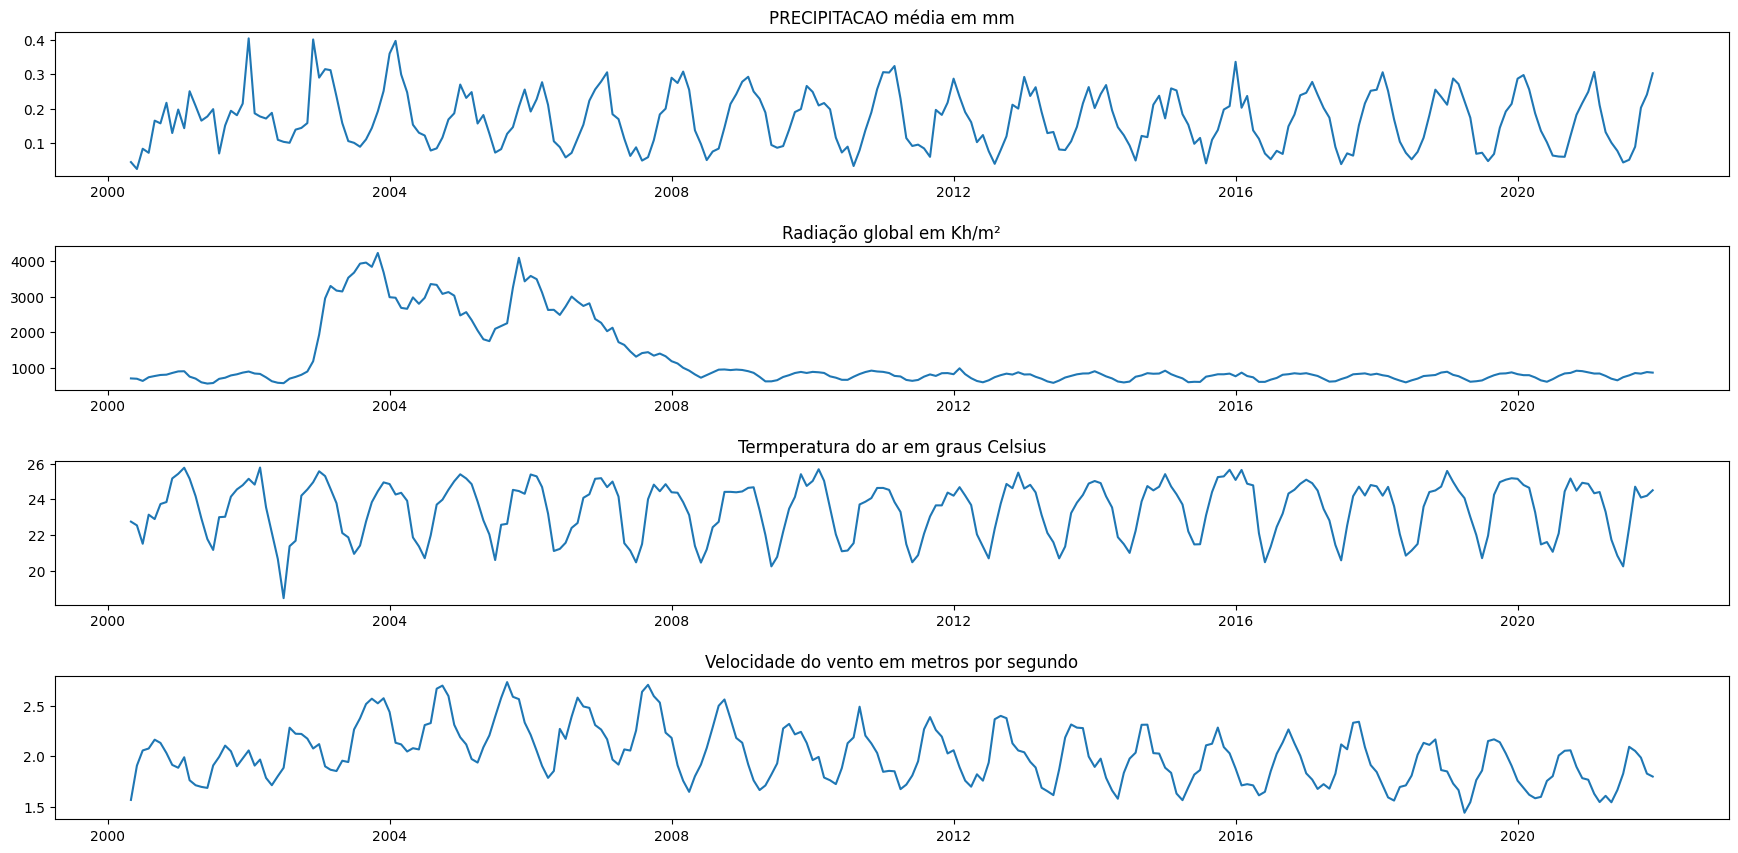

In [ ]:
#Como se comportam as variáveis climáticas no território nacional?

fig, ax = plt.subplots(4)
fig.set_size_inches(18, 9)
fig.tight_layout(pad=3.0)

ax[0].plot(met_data['PRECIPITACAO'])
ax[0].set_title('PRECIPITACAO média em mm')
ax[1].plot(met_data['RAD_GLOBAL'])
ax[1].set_title('Radiação global em Kh/m²')
ax[2].plot(met_data['TEMP_AR'])
ax[2].set_title('Termperatura do ar em graus Celsius')
ax[3].plot(met_data['VELOC_VENTO'])
ax[3].set_title('Velocidade do vento em metros por segundo')
plt.savefig('Imagens/Gráfico_12')
plt.show()



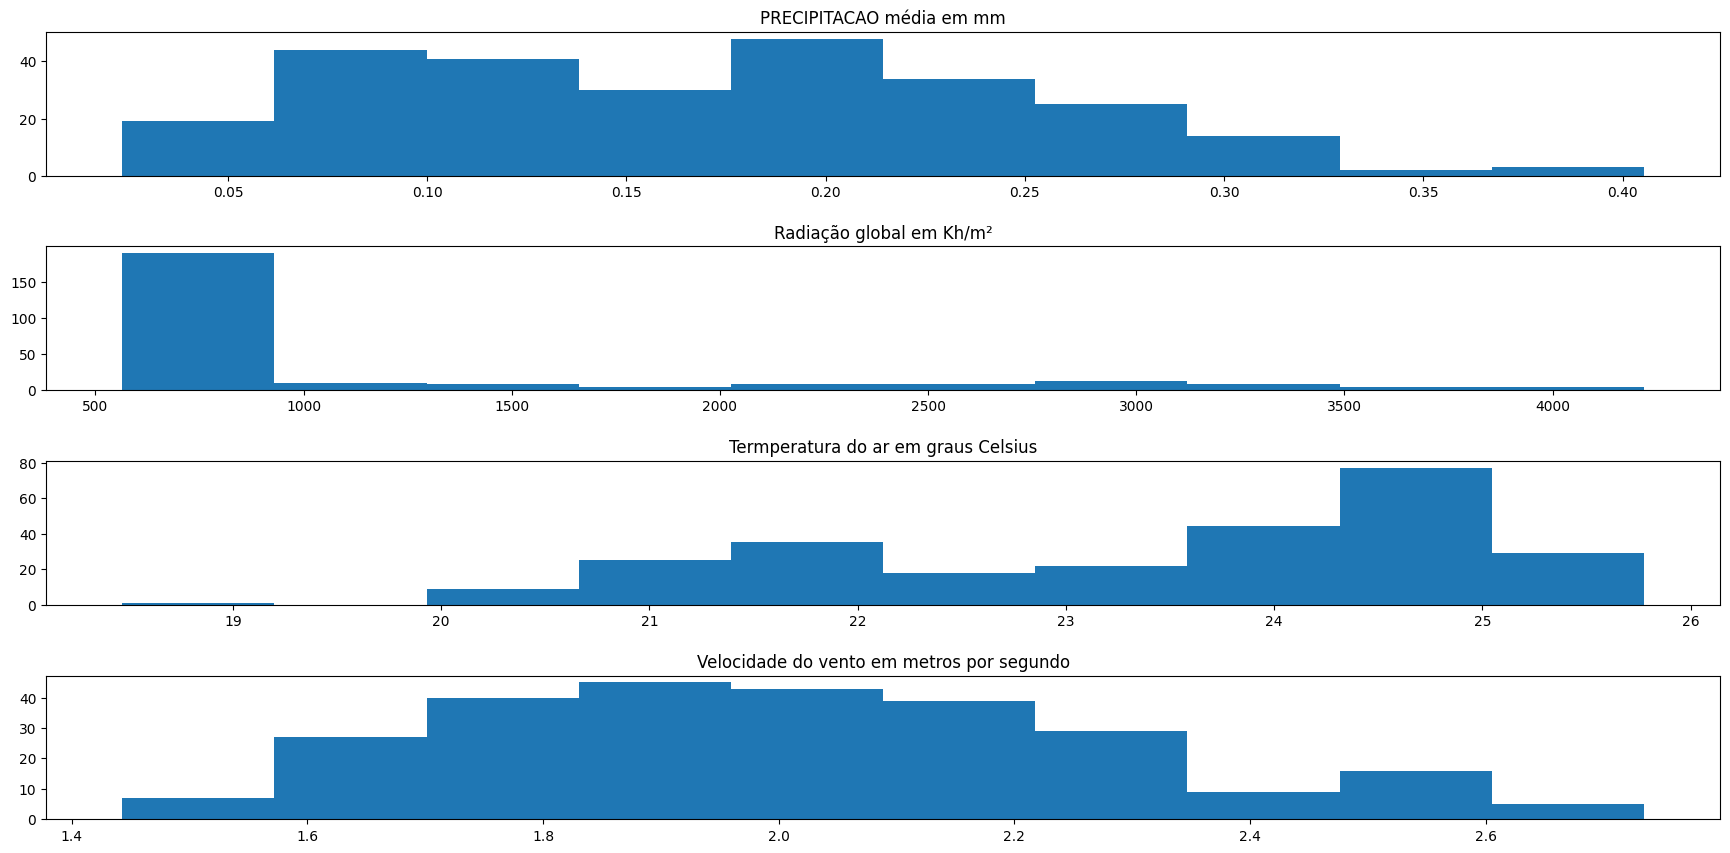

,PRECIPITACAO,RAD_GLOBAL,TEMP_AR,VELOC_VENTO
count,260.000000,260.000000,260.000000,260.000000
mean,0.169580,1222.541132,23.449784,2.015842
std,0.081197,890.341458,1.526916,0.273818
min,0.023426,564.311245,18.468505,1.442786
25%,0.100297,739.391437,22.089129,1.804550
50%,0.170148,829.479397,23.946172,1.996905
75%,0.232179,967.389317,24.685951,2.186565
max,0.405373,4219.225550,25.775236,2.734249


In [ ]:
#Como se comportam as variáveis climáticas no território nacional?



fig, ax = plt.subplots(4)
fig.set_size_inches(18, 9)
fig.tight_layout(pad=3.0)

ax[0].hist(met_data['PRECIPITACAO'])
ax[0].set_title('PRECIPITACAO média em mm')
ax[1].hist(met_data['RAD_GLOBAL'])
ax[1].set_title('Radiação global em Kh/m²')
ax[2].hist(met_data['TEMP_AR'])
ax[2].set_title('Termperatura do ar em graus Celsius')
ax[3].hist(met_data['VELOC_VENTO'])
ax[3].set_title('Velocidade do vento em metros por segundo')
plt.savefig('Imagens/Gráfico_13')
plt.show()

met_data.describe()



##fazer teste de estacionaridade

In [ ]:
#testes de estacionariedade para variáveis mensais

dfuller_met=pd.DataFrame()

for i in ['PRECIPITACAO', 'RAD_GLOBAL', 'TEMP_AR',
       'VELOC_VENTO']:
  dftest = adfuller(met_data[i], autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  dfuller_met[i]=dfoutput

dfi.export(dfuller_met, 'Imagens/dfuller_met.png', table_conversion='matplotlib',fontsize=12)
dfuller_met

,PRECIPITACAO,RAD_GLOBAL,TEMP_AR,VELOC_VENTO
Test Statistic,-4.142178,-1.833713,-3.662941,-1.171997
p-value,0.000824,0.363857,0.004666,0.685525
#Lags Used,10.000000,8.000000,14.000000,14.000000
Number of Observations Used,249.000000,251.000000,245.000000,245.000000
Critical Value (1%),-3.456888,-3.456674,-3.457326,-3.457326
Critical Value (5%),-2.873219,-2.873125,-2.873410,-2.873410
Critical Value (10%),-2.572994,-2.572944,-2.573096,-2.573096


##Verificando tendência e sazonalidade

In [ ]:
met_data=met_data.reset_index().reset_index().rename(columns={'index':'T'})
met_data['M']=pd.DataFrame(met_data['Ano_Mês'].apply(lambda x:str(x)[5:7]))
met_data.set_index('Ano_Mês',inplace=True)

for i in ['PRECIPITACAO', 'RAD_GLOBAL', 'TEMP_AR',
       'VELOC_VENTO']:
       formula=str(i)+'~T+M'
       trend_reg=smf.ols(formula=formula, data=met_data).fit()
       print('Regressão de ' + str(i)+' em relação ao tempo')
       print(trend_reg.summary())

met_data.drop(columns={ 'T','M'},inplace=True)


Regressão de PRECIPITACAO em relação ao tempo
                            OLS Regression Results                            
Dep. Variable:           PRECIPITACAO   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     76.33
Date:                Sat, 22 Apr 2023   Prob (F-statistic):           6.59e-76
Time:                        21:08:31   Log-Likelihood:                 485.82
No. Observations:                 260   AIC:                            -945.6
Df Residuals:                     247   BIC:                            -899.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

#Análise de Correlação das variáveis

---



In [ ]:
df3=df3.merge(gdp,left_index=True,right_index=True)
df3.drop(columns={'PIB', 'INPC'},inplace=True)
df3=df3.merge(met_data,left_index=True,right_index=True)
df3=df3.reset_index()
df3.rename(columns={'index':'Ano_Mês'}, inplace=True)
df3['T']=df3['T']-4
df3['M']=pd.DataFrame(df3['M'].apply(lambda x:'M'+str(x)))

for i in df3.columns[9:13]:
  nome1=str(i)[0:4]+'_logt'
  df3[nome1]=np.log(df3[i])
  nome2=nome1[0:6]+'diff'
  df3[nome2]=df3[nome1].diff(periods=1).fillna(value=0)
  df3.drop(columns={nome1},inplace=True)
  del(nome1,nome2)

df3.head()

,Ano_Mês,T,carga,M,log_carga,lcg_1st_diff,PIB_pc,log_PIBc,lPIBc_1diff,PRECIPITACAO,RAD_GLOBAL,TEMP_AR,VELOC_VENTO,PREC_ldiff,RAD__ldiff,TEMP_ldiff,VELO_ldiff
0,2000-05-01,0,40408.382258,M05,10.606793,0.004798,6163.657477,8.726426,0.077873,0.043618,708.817298,22.749734,1.569517,0.000000,0.000000,0.000000,0.000000
1,2000-06-01,1,40544.964444,M06,10.610167,0.003374,6391.592025,8.762739,0.036313,0.023426,699.272548,22.539826,1.909051,-0.621616,-0.013557,-0.009270,0.195839
2,2000-07-01,2,39964.849906,M07,10.595756,-0.014411,6348.480570,8.755971,-0.006768,0.082616,638.134525,21.511641,2.058742,1.260366,-0.091491,-0.046690,0.075489
3,2000-08-01,3,41074.001075,M08,10.623131,0.027375,6379.786608,8.760890,0.004919,0.070787,741.659644,23.138155,2.077949,-0.154541,0.150341,0.072889,0.009286
4,2000-09-01,4,41075.071542,M09,10.623157,0.000026,6058.319744,8.709188,-0.051702,0.164844,775.839620,22.891764,2.165117,0.845332,0.045055,-0.010706,0.041093


In [ ]:
#exportar csv

directoryPath_tempo = '/content/gdrive/MyDrive/Dissertação_SMendes'
df3.to_csv("dados_consolidados.csv", index=False, encoding='UTF-8')
#test_set.to_csv("conjunto_teste_dados_mes.csv", index=False, encoding='UTF-8')

<ipython-input-65-5a1d2249a9c5>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cormatrix1=df_l.corr()


,log_carga
log_carga,1.000000
log_PIBc,0.932471
PRECIPITACAO,0.053823
RAD_GLOBAL,-0.451440
TEMP_AR,0.189195
VELOC_VENTO,-0.325520


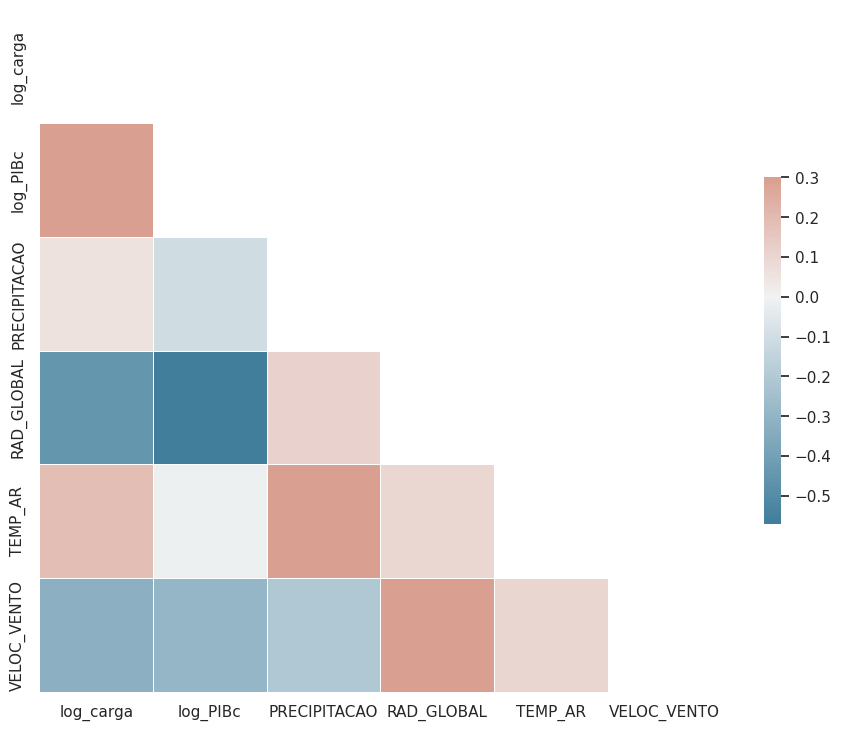

In [ ]:
df_l=df3.copy()



df_l.drop(columns={'T','M','carga','PIB_pc','lcg_1st_diff','lPIBc_1diff','PREC_ldiff','RAD__ldiff','TEMP_ldiff','VELO_ldiff'},inplace=True)


cormatrix1=df_l.corr()



sns.set_theme(style="white")
mask = np.triu(np.ones_like(cormatrix1, dtype=bool))
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(cormatrix1, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('Imagens/graf_cor1')

dfi.export(pd.DataFrame(cormatrix1['log_carga']), 'Imagens/cormatrix1.png', table_conversion='matplotlib',fontsize=12)
pd.DataFrame(cormatrix1['log_carga'])

<ipython-input-66-7ad5dbc0edfa>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cormatrix2=df_l.corr()


,lcg_1st_diff
lcg_1st_diff,1.000000
log_PIBc,0.013285
lPIBc_1diff,0.079152
PRECIPITACAO,-0.023344
RAD_GLOBAL,0.080098
TEMP_AR,0.305889
VELOC_VENTO,0.344941
PREC_ldiff,0.157192
RAD__ldiff,0.418365
TEMP_ldiff,0.629196


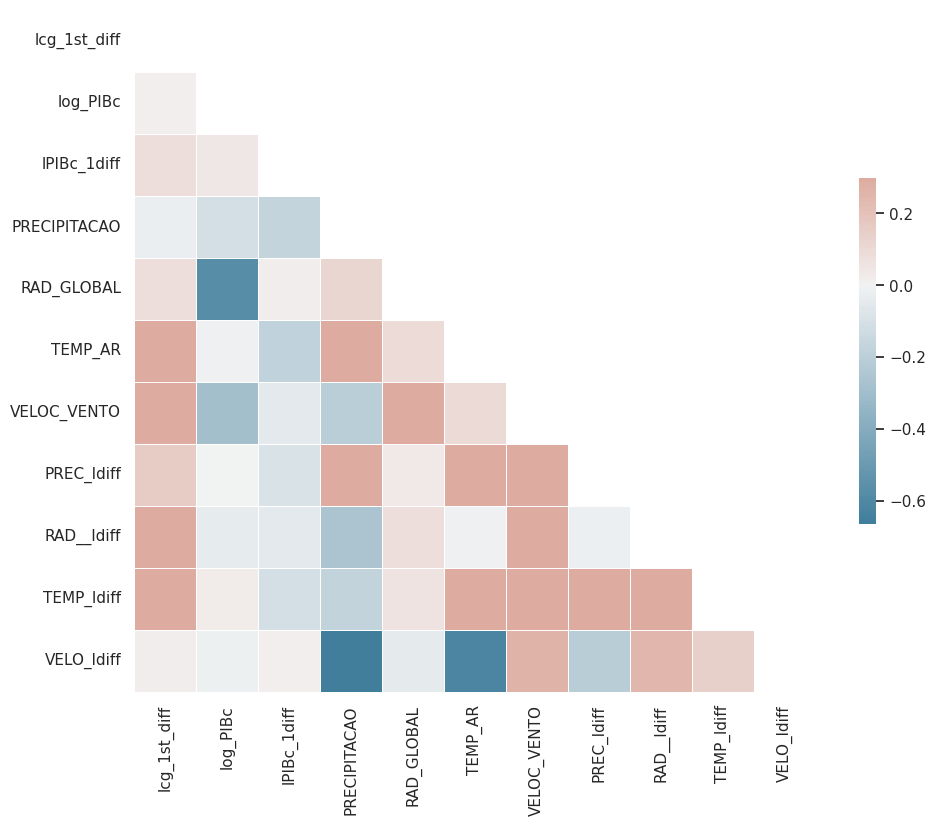

In [ ]:
df_l=df3.copy()

df_l.drop(columns={'T','M','carga','log_carga','PIB_pc',},inplace=True)


cormatrix2=df_l.corr()

sns.set_theme(style="white")
mask = np.triu(np.ones_like(cormatrix2, dtype=bool))
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(cormatrix2, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('Imagens/graf_cor2')

dfi.export(pd.DataFrame(cormatrix2['lcg_1st_diff']), 'Imagens/cormatrix2.png', table_conversion='matplotlib',fontsize=12)
pd.DataFrame(cormatrix2['lcg_1st_diff'])

#PIB x CARGA

##Modelo SVR com PIB

###variáveis em log

In [ ]:
np.random.seed(42)

tf.random.set_seed(42)

In [ ]:
train_set2=df3.set_index('Ano_Mês').drop(columns={'T',  'M', 'carga', 'lcg_1st_diff',
        'PIB_pc', 'lPIBc_1diff', 'PRECIPITACAO',
       'RAD_GLOBAL', 'TEMP_AR', 'VELOC_VENTO', 'PREC_ldiff', 'RAD__ldiff',
       'TEMP_ldiff', 'VELO_ldiff'}).loc['2003-01':'2017-12']
test_set2=df3.set_index('Ano_Mês').drop(columns={'T',  'M', 'carga', 'lcg_1st_diff',
        'PIB_pc', 'lPIBc_1diff', 'PRECIPITACAO',
       'RAD_GLOBAL', 'TEMP_AR', 'VELOC_VENTO', 'PREC_ldiff', 'RAD__ldiff',
       'TEMP_ldiff', 'VELO_ldiff'}).loc['2018-01-01':]

print('Conjunto de treino tem comprimento ',len(train_set2),len(train_set2)/len(df3.set_index('Ano_Mês').loc['2003-01':]))
print('Conjunto de teste tem comprimento ',len(test_set2),len(test_set2)/len(df3.set_index('Ano_Mês').loc['2003-01':]))

#Escalonamento

scaler=MinMaxScaler(feature_range=(0,1))

scaler = scaler.fit(train_set2)
sc_train = scaler.transform(train_set2)
sc_test= scaler.transform(test_set2)

# Separar variáveis explicativas e os rótulos

x_variables, labels = sc_train[:, 1:], sc_train[:, 0]
x_test, y_test = sc_test[:, 1:], sc_test[:, 0]


print('Conjuntos de treino tem o mesmo comprimento?', len(x_variables)==len(labels))


Conjunto de treino tem comprimento  180 0.7894736842105263
Conjunto de teste tem comprimento  48 0.21052631578947367
Conjuntos de treino tem o mesmo comprimento? True


In [ ]:
## treinando o svm

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid_svr=[{"kernel":['linear','poly'],
                 "degree":[1,2,3],
                 "C":[1,2,3,5,8,13],
                 "epsilon":[0.1,0.3,0.6,0.9,1.2,1.5]}]

svm_reg=SVR()

grid_search_svr=GridSearchCV(svm_reg,param_grid_svr,cv=5,scoring='neg_mean_squared_error',return_train_score=True)
grid_search_svr.fit(x_variables,labels)

# Melhor estimador de SVR

print(grid_search_svr.best_params_)
grid_search_svr.best_estimator_


{'C': 1, 'degree': 1, 'epsilon': 0.1, 'kernel': 'linear'}


SVR(C=1, degree=1, kernel='linear')

In [ ]:
#One step Forecast

svr_model_1=grid_search_svr.best_estimator_
preds5 = svr_model_1.predict(x_test)

df_pred=pd.DataFrame(preds5)
x_test_df=pd.DataFrame(x_test)
df_pred=pd.merge(df_pred,x_test_df,left_index=True,right_index=True)
array_pred=np.array(df_pred)

#desescalonar
preds5 = scaler.inverse_transform(array_pred)

# Make as pandas series
preds5_series = np.exp(pd.Series(preds5[:,0], index=test_set.index))


mae = metrics.mean_absolute_error(test_set['carga'], preds5_series)
mape=metrics.mean_absolute_percentage_error(test_set['carga'], preds5_series)
mse = metrics.mean_squared_error(test_set['carga'], preds5_series)
rmse = np.sqrt(mse) # or mse**(0.5)

accu_dict={"Model":'SVR1',"MAE":mae,"MAPE":mape,"MSE":mse,"RMSE":rmse}

accu_meds5=pd.DataFrame(accu_dict.keys())
accu_meds5[1]=pd.DataFrame(accu_dict.values())
accu_meds5=accu_meds5.set_index(0).T.set_index('Model')

dfi.export(accu_meds5, 'Imagens/accu_meds5.png', table_conversion='matplotlib',fontsize=12)

accu_meds5


,MAE,MAPE,MSE,RMSE
Model,,,,
SVR1,5177.260844,0.077023,38011644.344378,6165.358412


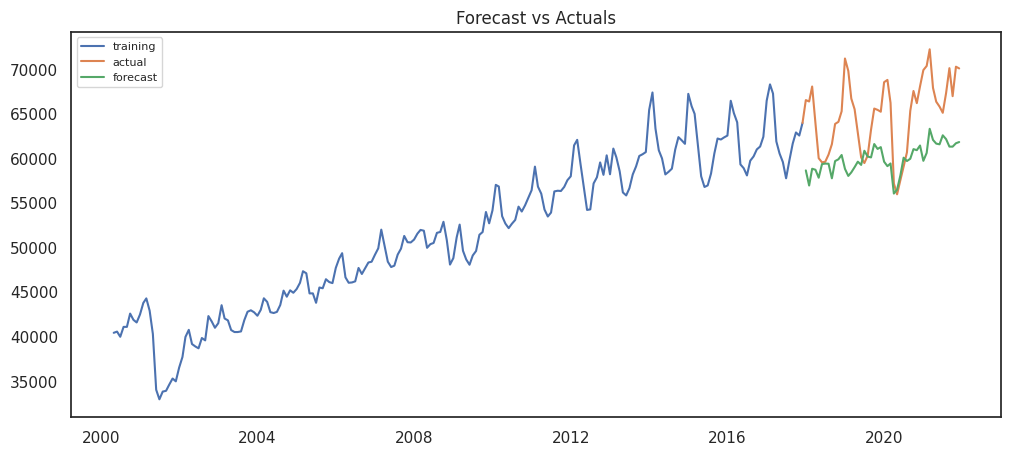

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df3.set_index('Ano_Mês').loc[:'2017-12-01']['carga'], label='training')
plt.plot(df3.set_index('Ano_Mês').loc['2017-12-01':]['carga'], label='actual')
plt.plot(preds5_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('Imagens/Gráfico_16a')
plt.show()



### variáveis em diferenças

In [ ]:
np.random.seed(42)

tf.random.set_seed(42)

In [ ]:
train_set2=df3.set_index('Ano_Mês').drop(columns={'T',  'M','carga', 'log_carga', 
        'log_PIBc', 'PIB_pc', 'PRECIPITACAO',
       'RAD_GLOBAL', 'TEMP_AR', 'VELOC_VENTO', 'PREC_ldiff', 'RAD__ldiff',
       'TEMP_ldiff', 'VELO_ldiff'}).loc['2003-01':'2017-12']
test_set2=df3.set_index('Ano_Mês').drop(columns={'T',  'M','carga', 'log_carga', 
        'log_PIBc', 'PIB_pc', 'PRECIPITACAO',
       'RAD_GLOBAL', 'TEMP_AR', 'VELOC_VENTO', 'PREC_ldiff', 'RAD__ldiff',
       'TEMP_ldiff', 'VELO_ldiff'}).loc['2018-01-01':]

print('Conjunto de treino tem comprimento ',len(train_set2),len(train_set2)/len(df3.set_index('Ano_Mês').loc['2003-01':]))
print('Conjunto de teste tem comprimento ',len(test_set2),len(test_set2)/len(df3.set_index('Ano_Mês').loc['2003-01':]))

#Escalonamento

scaler=MinMaxScaler(feature_range=(0,1))

scaler = scaler.fit(train_set2)
sc_train = scaler.transform(train_set2)
sc_test= scaler.transform(test_set2)

# Separar variáveis explicativas e os rótulos

x_variables, labels = sc_train[:, 1:], sc_train[:, 0]
x_test, y_test = sc_test[:, 1:], sc_test[:, 0]


print('Conjuntos de treino tem o mesmo comprimento?', len(x_variables)==len(labels))


Conjunto de treino tem comprimento  180 0.7894736842105263
Conjunto de teste tem comprimento  48 0.21052631578947367
Conjuntos de treino tem o mesmo comprimento? True


In [ ]:
## treinando o svm

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid_svr=[{"kernel":['linear','poly'],
                 "degree":[1,2,3],
                 "C":[1,2,3,5,8,13],
                 "epsilon":[0.1,0.3,0.6,0.9,1.2,1.5]}]

svm_reg=SVR()

grid_search_svr=GridSearchCV(svm_reg,param_grid_svr,cv=5,scoring='neg_mean_squared_error',return_train_score=True)
grid_search_svr.fit(x_variables,labels)

# Melhor estimador de SVR

print(grid_search_svr.best_params_)
grid_search_svr.best_estimator_


{'C': 1, 'degree': 1, 'epsilon': 0.6, 'kernel': 'linear'}


SVR(C=1, degree=1, epsilon=0.6, kernel='linear')

In [ ]:
#One step Forecast

svr_model_2=grid_search_svr.best_estimator_
preds6 = svr_model_2.predict(x_test)

df_pred=pd.DataFrame(preds6)
x_test_df=pd.DataFrame(x_test)
df_pred=pd.merge(df_pred,x_test_df,left_index=True,right_index=True)
array_pred=np.array(df_pred)

#desescalonar
preds6 = scaler.inverse_transform(array_pred)

# Make as pandas series
preds6_series = pd.Series(preds6[:,0], index=test_set.index)

#retornar para valores de linha

preds6_series=preds6_series.cumsum()
log_carga_inic=df3.set_index('Ano_Mês').loc['2017-12']['log_carga']
log_carga_inic=log_carga_inic.reset_index()['log_carga']
preds6_series=preds6_series.apply(lambda x:x+log_carga_inic)
preds6_series=np.exp(preds6_series)


mae = metrics.mean_absolute_error(df3.set_index('Ano_Mês').loc['2018-01-01':]['carga'], preds6_series)
mape=metrics.mean_absolute_percentage_error(df3.set_index('Ano_Mês').loc['2018-01-01':]['carga'], preds6_series)
mse = metrics.mean_squared_error(df3.set_index('Ano_Mês').loc['2018-01-01':]['carga'], preds6_series)
rmse = np.sqrt(mse) # or mse**(0.5)

accu_dict={"Model":'SVR2',"MAE":mae,"MAPE":mape,"MSE":mse,"RMSE":rmse}

accu_meds6=pd.DataFrame(accu_dict.keys())
accu_meds6[1]=pd.DataFrame(accu_dict.values())
accu_meds6=accu_meds6.set_index(0).T.set_index('Model')

dfi.export(accu_meds6, 'Imagens/accu_meds6.png', table_conversion='matplotlib',fontsize=12)

accu_meds6


,MAE,MAPE,MSE,RMSE
Model,,,,
SVR2,3299.198517,0.053155,18820539.540469,4338.264577


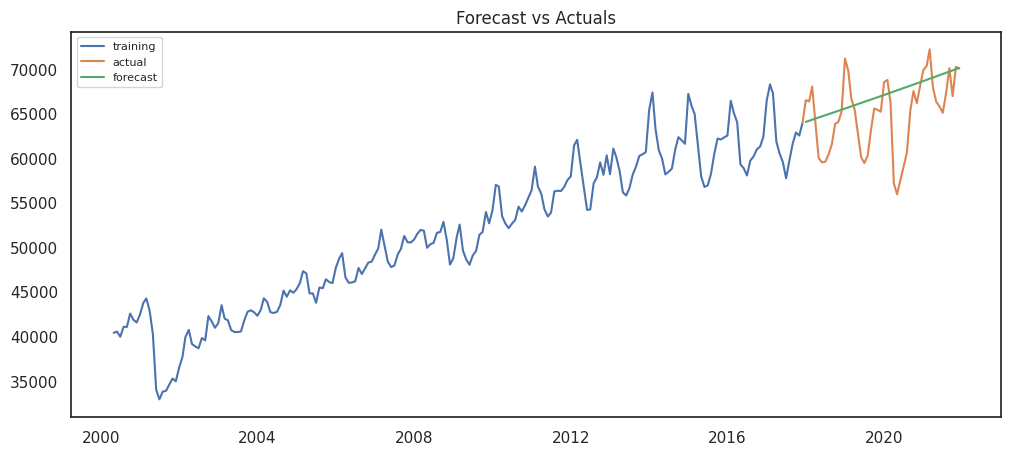

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df3.set_index('Ano_Mês').loc[:'2017-12-01']['carga'], label='training')
plt.plot(df3.set_index('Ano_Mês').loc['2017-12-01':]['carga'], label='actual')
plt.plot(preds6_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('Imagens/Gráfico_16b')
plt.show()



#CARGA x PIB +MET

##Modelo SVR com PIB e MET

###variáveis em log

In [ ]:
np.random.seed(42)

tf.random.set_seed(42)

In [ ]:
train_set2=df3.set_index('Ano_Mês').drop(columns={'T',  'M', 'carga', 'lcg_1st_diff',
        'PIB_pc', 'lPIBc_1diff', 'PREC_ldiff', 'RAD__ldiff',
       'TEMP_ldiff', 'VELO_ldiff'}).loc['2003-01':'2017-12']
test_set2=df3.set_index('Ano_Mês').drop(columns={'T',  'M', 'carga', 'lcg_1st_diff',
        'PIB_pc', 'lPIBc_1diff',  'PREC_ldiff', 'RAD__ldiff',
       'TEMP_ldiff', 'VELO_ldiff'}).loc['2018-01-01':]


print('Conjunto de treino tem comprimento ',len(train_set),len(train_set)/len(df3.set_index('Ano_Mês').loc['2003-01':]))
print('Conjunto de teste tem comprimento ',len(test_set),len(test_set)/len(df3.set_index('Ano_Mês').loc['2003-01':]))

#Escalonamento

scaler=MinMaxScaler(feature_range=(0,1))

scaler = scaler.fit(train_set2)
sc_train = scaler.transform(train_set2)
sc_test= scaler.transform(test_set2)

# Separar variáveis explicativas e os rótulos

x_variables, labels = sc_train[:, 1:], sc_train[:, 0]
x_test, y_test = sc_test[:, 1:], sc_test[:, 0]


print('Conjuntos de treino tem o mesmo comprimento?', len(x_variables)==len(labels))


Conjunto de treino tem comprimento  180 0.7894736842105263
Conjunto de teste tem comprimento  48 0.21052631578947367
Conjuntos de treino tem o mesmo comprimento? True


In [ ]:
## treinando o svm

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid_svr=[{"kernel":['linear','poly'],
                 "degree":[1,2,3],
                 "C":[1,2,3,5,8,13],
                 "epsilon":[0.1,0.3,0.6,0.9,1.2,1.5]}]

svm_reg=SVR()

grid_search_svr=GridSearchCV(svm_reg,param_grid_svr,cv=5,scoring='neg_mean_squared_error',return_train_score=True)
grid_search_svr.fit(x_variables,labels)

# Melhor estimador de SVR

print(grid_search_svr.best_params_)
grid_search_svr.best_estimator_


{'C': 2, 'degree': 1, 'epsilon': 0.1, 'kernel': 'linear'}


SVR(C=2, degree=1, kernel='linear')

In [ ]:
#One step Forecast

svr_model_3=grid_search_svr.best_estimator_
preds7 = svr_model_3.predict(x_test)

df_pred=pd.DataFrame(preds7)
x_test_df=pd.DataFrame(x_test)
df_pred=pd.merge(df_pred,x_test_df,left_index=True,right_index=True)
array_pred=np.array(df_pred)

#desescalonar
preds7 = scaler.inverse_transform(array_pred)

# Make as pandas series
preds7_series = np.exp(pd.Series(preds7[:,0], index=test_set.index))


mae = metrics.mean_absolute_error(test_set['carga'], preds7_series)
mape=metrics.mean_absolute_percentage_error(test_set['carga'], preds7_series)
mse = metrics.mean_squared_error(test_set['carga'], preds7_series)
rmse = np.sqrt(mse) # or mse**(0.5)

accu_dict={"Model":'SVR3',"MAE":mae,"MAPE":mape,"MSE":mse,"RMSE":rmse}

accu_meds7=pd.DataFrame(accu_dict.keys())
accu_meds7[1]=pd.DataFrame(accu_dict.values())
accu_meds7=accu_meds7.set_index(0).T.set_index('Model')

dfi.export(accu_meds7, 'Imagens/accu_meds7.png', table_conversion='matplotlib',fontsize=12)

accu_meds7


,MAE,MAPE,MSE,RMSE
Model,,,,
SVR3,3830.684248,0.057471,20123140.186031,4485.88232


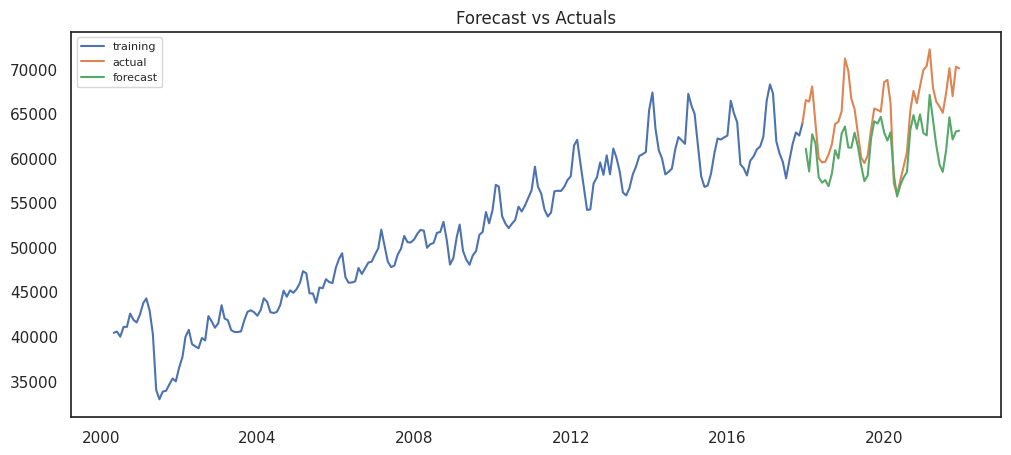

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df3.set_index('Ano_Mês').loc[:'2017-12-01']['carga'], label='training')
plt.plot(df3.set_index('Ano_Mês').loc['2017-12-01':]['carga'], label='actual')
plt.plot(preds7_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('Imagens/Gráfico_16c')
plt.show()



### variáveis em diferenças

In [ ]:
np.random.seed(42)

tf.random.set_seed(42)

In [ ]:
train_set2=df3.set_index('Ano_Mês').drop(columns={'T',  'M','carga', 'log_carga', 
        'log_PIBc', 'PIB_pc'#, 'PRECIPITACAO',
       }).loc['2003-01':'2017-12']
test_set2=df3.set_index('Ano_Mês').drop(columns={'T',  'M','carga', 'log_carga', 
        'log_PIBc', 'PIB_pc'#, 'PRECIPITACAO',
        }).loc['2018-01-01':]

print('Conjunto de treino tem comprimento ',len(train_set2),len(train_set2)/len(df3.set_index('Ano_Mês').loc['2003-01':]))
print('Conjunto de teste tem comprimento ',len(test_set2),len(test_set2)/len(df3.set_index('Ano_Mês').loc['2003-01':]))

#Escalonamento

scaler=MinMaxScaler(feature_range=(0,1))

scaler = scaler.fit(train_set2)
sc_train = scaler.transform(train_set2)
sc_test= scaler.transform(test_set2)

# Separar variáveis explicativas e os rótulos

x_variables, labels = sc_train[:, 1:], sc_train[:, 0]
x_test, y_test = sc_test[:, 1:], sc_test[:, 0]


print('Conjuntos de treino tem o mesmo comprimento?', len(x_variables)==len(labels))


Conjunto de treino tem comprimento  180 0.7894736842105263
Conjunto de teste tem comprimento  48 0.21052631578947367
Conjuntos de treino tem o mesmo comprimento? True


In [ ]:
## treinando o svm

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid_svr=[{"kernel":['linear','poly'],
                 "degree":[1,2,3],
                 "C":[1,2,3,5,8,13],
                 "epsilon":[0.1,0.3,0.6,0.9,1.2,1.5]}]

svm_reg=SVR()

grid_search_svr=GridSearchCV(svm_reg,param_grid_svr,cv=5,scoring='neg_mean_squared_error',return_train_score=True)
grid_search_svr.fit(x_variables,labels)

# Melhor estimador de SVR

print(grid_search_svr.best_params_)
grid_search_svr.best_estimator_


{'C': 1, 'degree': 2, 'epsilon': 0.1, 'kernel': 'poly'}


SVR(C=1, degree=2, kernel='poly')

In [ ]:
#One step Forecast

svr_model_4=grid_search_svr.best_estimator_
preds8 = svr_model_4.predict(x_test)

df_pred=pd.DataFrame(preds8)
x_test_df=pd.DataFrame(x_test)
df_pred=pd.merge(df_pred,x_test_df,left_index=True,right_index=True)
array_pred=np.array(df_pred)

#desescalonar
preds8 = scaler.inverse_transform(array_pred)

# Make as pandas series
preds8_series = pd.Series(preds8[:,0], index=test_set.index)

#retornar para valores de linha

preds8_series=preds8_series.cumsum()
log_carga_inic=df3.set_index('Ano_Mês').loc['2017-12']['log_carga']
log_carga_inic=log_carga_inic.reset_index()['log_carga']
preds8_series=preds8_series.apply(lambda x:x+log_carga_inic)
preds8_series=np.exp(preds8_series)

mae = metrics.mean_absolute_error(df3.set_index('Ano_Mês').loc['2018-01-01':]['carga'], preds8_series)
mape=metrics.mean_absolute_percentage_error(df3.set_index('Ano_Mês').loc['2018-01-01':]['carga'], preds8_series)
mse = metrics.mean_squared_error(df3.set_index('Ano_Mês').loc['2018-01-01':]['carga'], preds8_series)
rmse = np.sqrt(mse) # or mse**(0.5)

accu_dict={"Model":'SVR4',"MAE":mae,"MAPE":mape,"MSE":mse,"RMSE":rmse}

accu_meds8=pd.DataFrame(accu_dict.keys())
accu_meds8[1]=pd.DataFrame(accu_dict.values())
accu_meds8=accu_meds8.set_index(0).T.set_index('Model')

dfi.export(accu_meds8, 'Imagens/accu_meds8.png', table_conversion='matplotlib',fontsize=12)

accu_meds8


,MAE,MAPE,MSE,RMSE
Model,,,,
SVR4,4477.810995,0.070091,29282546.108183,5411.334965


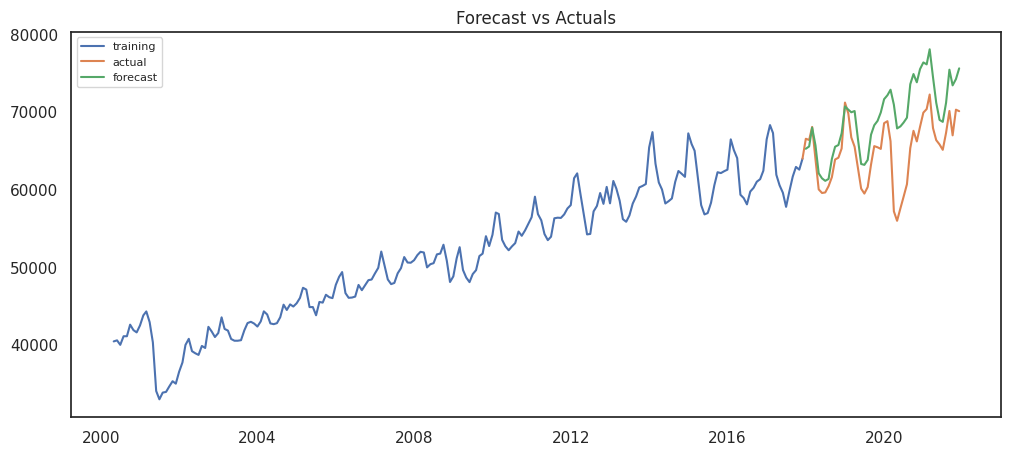

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df3.set_index('Ano_Mês').loc[:'2017-12-01']['carga'], label='training')
plt.plot(df3.set_index('Ano_Mês').loc['2017-12-01':]['carga'], label='actual')
plt.plot(preds8_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('Imagens/Gráfico_16d')
plt.show()



#Importar séries de previsões produzidas no RStudio


VARpreds1.csv


<ipython-input-91-af146de69990>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accu_medsR=accu_medsR.append(accu_medsRt)


VECM1


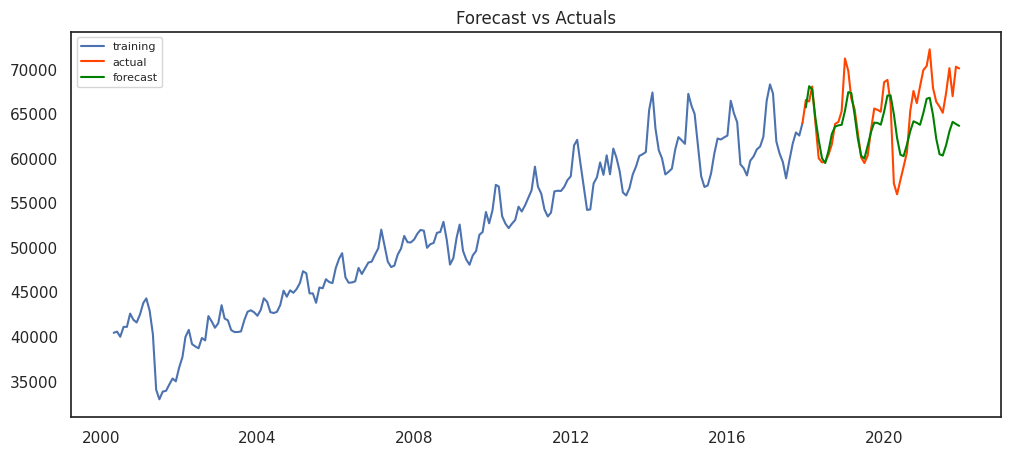

VARpreds2.csv


<ipython-input-91-af146de69990>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accu_medsR=accu_medsR.append(accu_medsRt)


VECM2


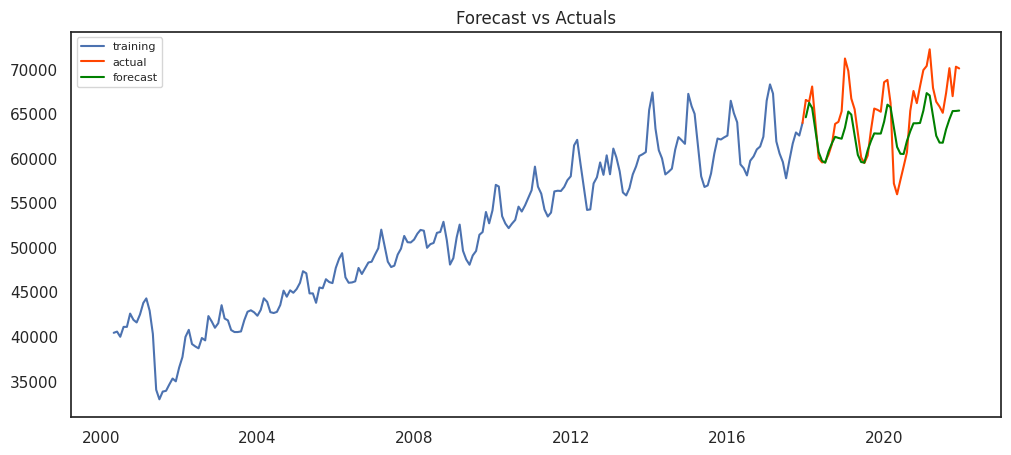

VARpreds3.csv


<ipython-input-91-af146de69990>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accu_medsR=accu_medsR.append(accu_medsRt)


VECM3


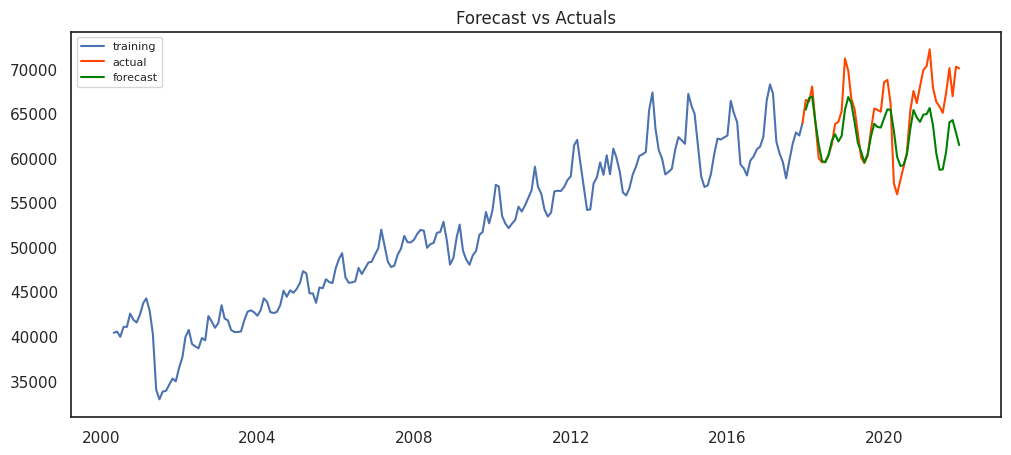

ADLpreds1.csv


<ipython-input-91-af146de69990>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accu_medsR=accu_medsR.append(accu_medsRt)


ADL_ECM1


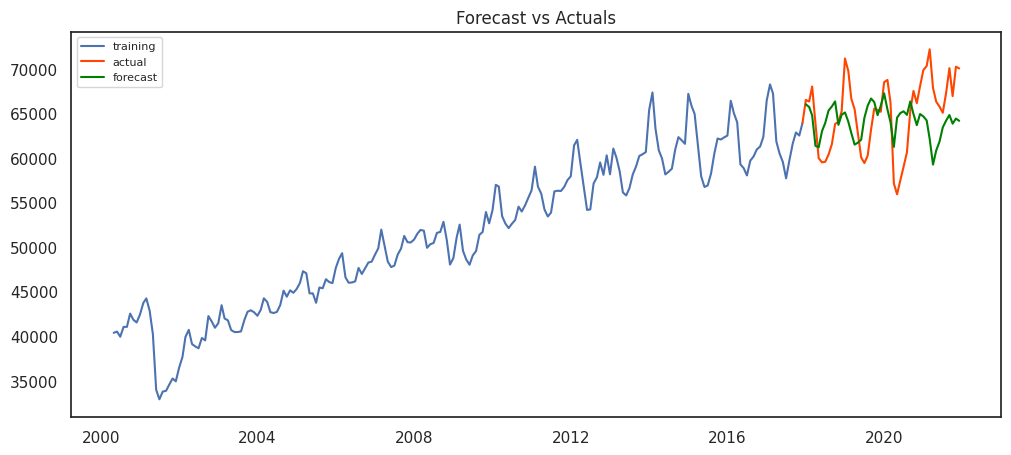

ADLpreds2.csv


<ipython-input-91-af146de69990>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accu_medsR=accu_medsR.append(accu_medsRt)


ADL_ECM2


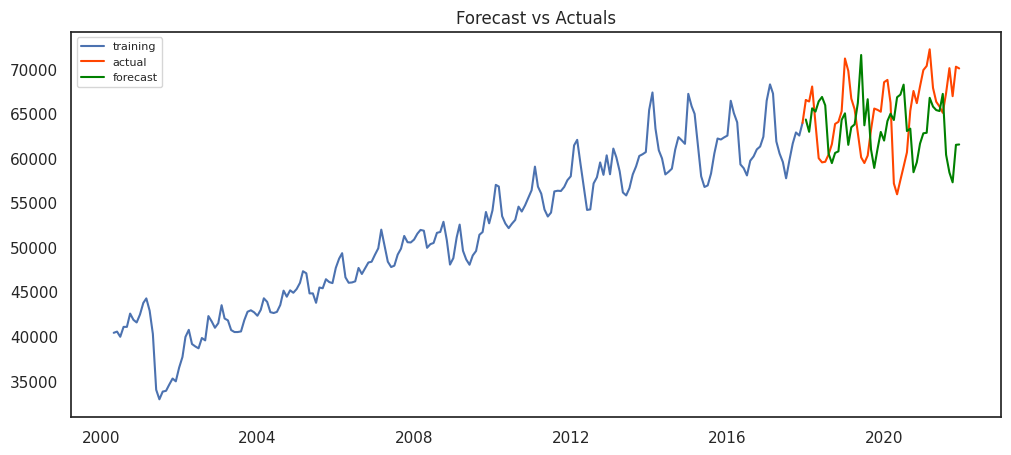

             carga_VECM1   carga_VECM2   carga_VECM3  carga_ADL_ECM1  \
Ano_Mês                                                                
2018-01-01  65712.000375  64602.658773  65459.499553    66055.465845   
2018-02-01  68090.218358  66232.359963  66774.719975    65759.060633   
2018-03-01  67725.272088  65633.679200  66928.302561    64812.108822   
2018-04-01  64457.641133  63092.150180  63989.650195    61396.855176   
2018-05-01  62045.524203  60681.926613  61569.723416    61232.756647   

            carga_ADL_ECM2  
Ano_Mês                     
2018-01-01    64348.743575  
2018-02-01    62969.008062  
2018-03-01    65606.219910  
2018-04-01    65236.117231  
2018-05-01    66384.874030  


,MAE,MAPE,MSE,RMSE
Model,,,,
VECM1,2574.906624,0.039129,11413013.710226,3378.315218
VECM2,2675.334129,0.040525,10502554.654714,3240.764517
VECM3,2740.536586,0.041131,13349595.578567,3653.709838
ADL_ECM1,3707.315133,0.057343,19214092.437049,4383.388237
ADL_ECM2,5137.013162,0.079609,36363500.839281,6030.215654


In [ ]:
a=0
v=0
m=8
g=16

accu_dict={"Model":"Modelo","MAE":0,"MAPE":0,"MSE":0,"RMSE":0}
accu_medsR=pd.DataFrame(accu_dict.keys())
accu_medsR[1]=pd.DataFrame(accu_dict.values())
accu_medsR=accu_medsR.set_index(0).T.set_index('Model')

Rforecasts=os.listdir('Rforecasts')
root_path2=root_path+'/Rforecasts'

for i in Rforecasts:
  print(i)
  m=m+1
  g=g+1
  caminho=root_path2+'/'+i
  RPredst=pd.read_csv(caminho)
  RPredst['Ano_Mês']=test_set.index
  RPredst.set_index('Ano_Mês',inplace=True)
  if i[0:3]=='ADL':
    RPredst.rename(columns={'x':'carga'},inplace=True)

  mae = metrics.mean_absolute_error(df3.set_index('Ano_Mês').loc['2018-01-01':]['carga'], RPredst['carga'])
  mape=metrics.mean_absolute_percentage_error(df3.set_index('Ano_Mês').loc['2018-01-01':]['carga'], RPredst['carga'])
  mse = metrics.mean_squared_error(df3.set_index('Ano_Mês').loc['2018-01-01':]['carga'], RPredst['carga'])
  rmse = np.sqrt(mse) # or mse**(0.5)
  
  if i[0:3]=='VAR':
    nome='VECM'+i[8]
  else:
    nome='ADL_ECM'+i[8]
  
    
  accu_dict={"Model":nome,"MAE":mae,"MAPE":mape,"MSE":mse,"RMSE":rmse}

  accu_medsRt=pd.DataFrame(accu_dict.keys())
  accu_medsRt[1]=pd.DataFrame(accu_dict.values())
  accu_medsRt=accu_medsRt.set_index(0).T.set_index('Model')

  accu_medsR=accu_medsR.append(accu_medsRt)

  dfi.export(accu_medsRt, 'Imagens/accu_meds'+str(m)+'.png', table_conversion='matplotlib',fontsize=12)
  print(nome)

  plt.figure(figsize=(12,5), dpi=100)
  plt.plot(df3.set_index('Ano_Mês').loc[:'2017-12-01']['carga'], label='training')
  plt.plot(df3.set_index('Ano_Mês').loc['2017-12':'2018-01']['carga'],color='#FF4500')
  plt.plot(df3.set_index('Ano_Mês').loc['2018-01-01':]['carga'], label='actual',color='#FF4500')
  plt.plot(RPredst['carga'], label='forecast',color='#008000')
  plt.title('Forecast vs Actuals')
  plt.legend(loc='upper left', fontsize=8)
  plt.savefig('Imagens/Gráfico_'+str(g))
  plt.show()

  if m==9:
    nome="carga_"+nome
    RPredst.rename(columns={'carga':nome},inplace=True)
    RPreds=RPredst.copy()
  else:
    nome="carga_"+nome
    RPredst.rename(columns={'carga':nome},inplace=True)
    RPreds=RPreds.merge(RPredst,right_index=True, left_index=True)

RPreds.drop(columns={'PIB_x','PIB_y','PIB'},axis=1,inplace=True)
print(RPreds.head())
accu_medsR.drop(['Modelo'],axis='index',inplace=True)
accu_medsR




#Comparando os modelos

In [ ]:

medidas=accu_meds1
medidas=medidas.append([accu_meds2,accu_meds3,accu_meds4,accu_meds5,accu_meds6,accu_meds7,accu_meds8,accu_medsR]).sort_values(by=['MAPE'])


dfi.export(medidas, 'Imagens/comparativo.png', table_conversion='matplotlib',fontsize=12)
medidas

<ipython-input-92-181bf45553b9>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  medidas=medidas.append([accu_meds2,accu_meds3,accu_meds4,accu_meds5,accu_meds6,accu_meds7,accu_meds8,accu_medsR]).sort_values(by=['MAPE'])


,MAE,MAPE,MSE,RMSE
Model,,,,
"SARIMA(1,1,1)(0,1,1)[12]",1648.433617,0.02625,6008905.15309,2451.306826
VECM1,2574.906624,0.039129,11413013.710226,3378.315218
VECM2,2675.334129,0.040525,10502554.654714,3240.764517
VECM3,2740.536586,0.041131,13349595.578567,3653.709838
SVR2,3299.198517,0.053155,18820539.540469,4338.264577
ADL_ECM1,3707.315133,0.057343,19214092.437049,4383.388237
SVR3,3830.684248,0.057471,20123140.186031,4485.88232
LSTM,3959.524731,0.060166,22140614.044052,4705.381392
"ARIMA(1,1,3)",4042.970819,0.061384,21324223.982989,4617.815932


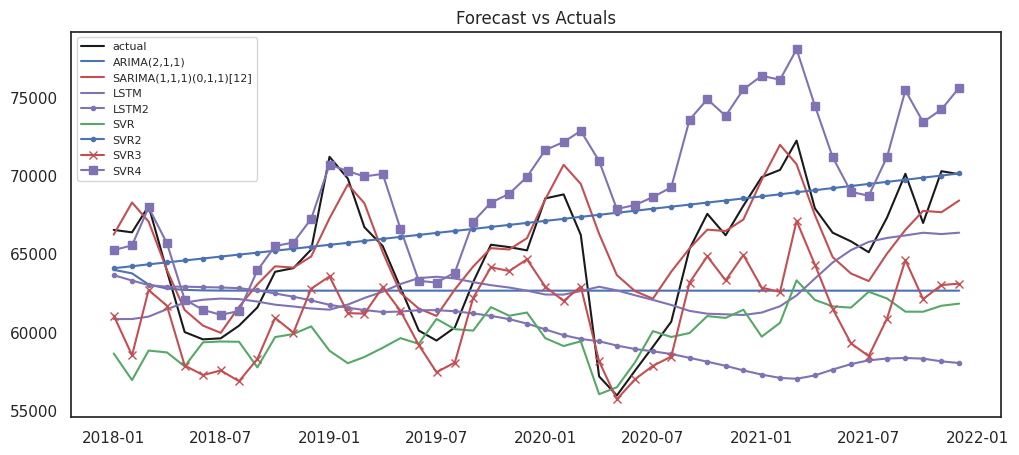

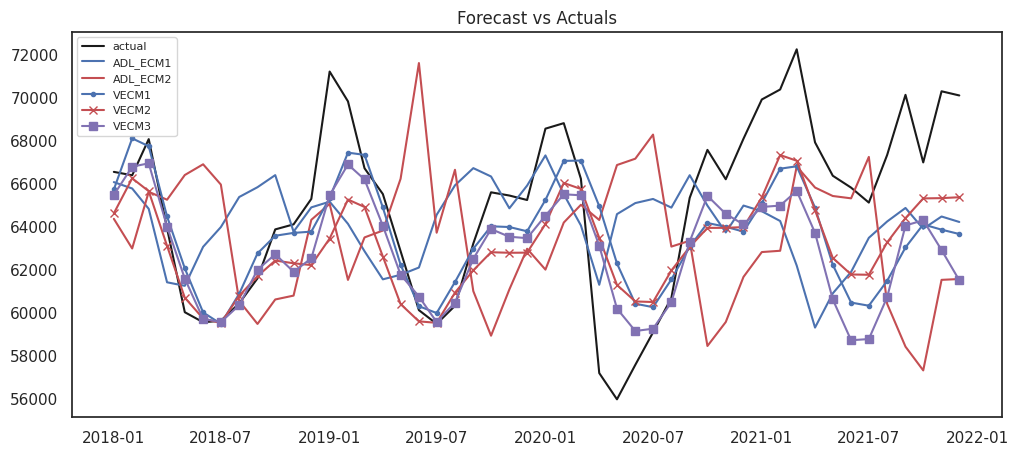

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(train_set['carga'], label='training')
plt.plot(test_set['carga'], label='actual',color='k')
plt.plot(preds1_series, label='ARIMA(2,1,1)')
plt.plot(preds2_series, label='SARIMA(1,1,1)(0,1,1)[12]',color='r')
plt.plot(preds3_series, label='LSTM',color='m')
plt.plot(preds4_series, label='LSTM2',color='m',marker='.')
plt.plot(preds5_series, label='SVR',color='g')
plt.plot(preds6_series, label='SVR2',color='b',marker='.')
plt.plot(preds7_series, label='SVR3',color='r',marker='x')
plt.plot(preds8_series, label='SVR4',color='m',marker='s')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

plt.savefig('Imagens/Gráfico_comp')

plt.show()


plt.figure(figsize=(12,5), dpi=100)
#plt.plot(train_set['carga'], label='training')
plt.plot(test_set['carga'], label='actual',color='k')
plt.plot(RPreds['carga_ADL_ECM1'], label='ADL_ECM1')
plt.plot(RPreds['carga_ADL_ECM2'], label='ADL_ECM2',color='r')
plt.plot(RPreds['carga_VECM1'], label='VECM1',color='b',marker='.')
plt.plot(RPreds['carga_VECM2'], label='VECM2',color='r',marker='x')
plt.plot(RPreds['carga_VECM3'], label='VECM3',color='m',marker='s')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

plt.savefig('Imagens/Gráfico_comp2')

plt.show()


In [ ]:
#Comparando acurácia dos modelos no biênio 2018-2019

j=0
preds_series=[preds1_series,preds2_series,preds3_series,preds4_series,
               preds5_series,preds6_series,preds7_series,preds8_series]

modelos=['ARIMA(1,1,3)',"SARIMA(1,1,1)(0,1,1)[12]","LSTM","LSTM2","SVR1","SVR2","SVR3","SVR4"]

for i in preds_series:
  j=j+1
  mae = metrics.mean_absolute_error(test_set['carga'].loc['2018-01':'2019-12'], i.loc['2018-01':'2019-12'])
  mape=metrics.mean_absolute_percentage_error(test_set['carga'].loc['2018-01':'2019-12'], i.loc['2018-01':'2019-12'])
  mse = metrics.mean_squared_error(test_set['carga'].loc['2018-01':'2019-12'], i.loc['2018-01':'2019-12'])
  rmse = np.sqrt(mse) # or mse**(0.5)
  accu_dict={"Model":modelos[j-1],"MAE":mae,"MAPE":mape,"MSE":mse,"RMSE":rmse}

  accu_meds_temp=pd.DataFrame(accu_dict.keys())
  accu_meds_temp[1]=pd.DataFrame(accu_dict.values())
  accu_meds_temp=accu_meds_temp.set_index(0).T.set_index('Model')
  if j==1:
    medidas_2018_2019=accu_meds_temp
  else: medidas_2018_2019=medidas_2018_2019.append(accu_meds_temp)

j=0
for i in RPreds.columns:
  j=j+1
  mae = metrics.mean_absolute_error(test_set['carga'].loc['2018-01':'2019-12'], RPreds[i].loc['2018-01':'2019-12'])
  mape=metrics.mean_absolute_percentage_error(test_set['carga'].loc['2018-01':'2019-12'], RPreds[i].loc['2018-01':'2019-12'])
  mse = metrics.mean_squared_error(test_set['carga'].loc['2018-01':'2019-12'], RPreds[i].loc['2018-01':'2019-12'])
  rmse = np.sqrt(mse) # or mse**(0.5)
  accu_dict={"Model":i[6:],"MAE":mae,"MAPE":mape,"MSE":mse,"RMSE":rmse}

  accu_meds_temp=pd.DataFrame(accu_dict.keys())
  accu_meds_temp[1]=pd.DataFrame(accu_dict.values())
  accu_meds_temp=accu_meds_temp.set_index(0).T.set_index('Model')
  
  medidas_2018_2019=medidas_2018_2019.append(accu_meds_temp)
  
 
medidas_2018_2019.sort_values(by=['MAPE'])


<ipython-input-94-5359720d4fef>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  else: medidas_2018_2019=medidas_2018_2019.append(accu_meds_temp)
<ipython-input-94-5359720d4fef>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  else: medidas_2018_2019=medidas_2018_2019.append(accu_meds_temp)
<ipython-input-94-5359720d4fef>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  else: medidas_2018_2019=medidas_2018_2019.append(accu_meds_temp)
<ipython-input-94-5359720d4fef>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  else: medidas_2018_2019=medidas_2018_2019.append(accu_meds_temp)
<ipython-input-94-5359720d4fef>:22: FutureWarning: The f

,MAE,MAPE,MSE,RMSE
Model,,,,
"SARIMA(1,1,1)(0,1,1)[12]",979.239271,0.015316,1736352.846166,1317.707421
VECM1,1106.151404,0.016837,2594117.905918,1610.626557
VECM3,1242.791616,0.018802,3127413.036329,1768.449331
VECM2,1786.321232,0.026915,6152808.443147,2480.485526
SVR4,2315.841148,0.036632,7057136.673586,2656.527183
"ARIMA(1,1,3)",2853.128362,0.043908,11540799.45533,3397.175217
ADL_ECM1,2800.105052,0.044039,11448849.747664,3383.614894
SVR2,3157.048921,0.050268,14005771.171878,3742.428513
SVR3,3307.668342,0.050701,15918916.796326,3989.851726


In [ ]:
#Comparando acurácia dos modelos no biênio 2020-2021

j=0
preds_series=[preds1_series,preds2_series,preds3_series,preds4_series,
               preds5_series,preds6_series,preds7_series,preds8_series]

modelos=['ARIMA(1,1,3)',"SARIMA(1,1,1)(0,1,1)[12]","LSTM","LSTM2","SVR1","SVR2","SVR3","SVR4"]

for i in preds_series:
  j=j+1
  mae = metrics.mean_absolute_error(test_set['carga'].loc['2020-01':'2021-12'], i.loc['2020-01':'2021-12'])
  mape=metrics.mean_absolute_percentage_error(test_set['carga'].loc['2020-01':'2021-12'], i.loc['2020-01':'2021-12'])
  mse = metrics.mean_squared_error(test_set['carga'].loc['2020-01':'2021-12'], i.loc['2020-01':'2021-12'])
  rmse = np.sqrt(mse) # or mse**(0.5)
  accu_dict={"Model":modelos[j-1],"MAE":mae,"MAPE":mape,"MSE":mse,"RMSE":rmse}

  accu_meds_temp=pd.DataFrame(accu_dict.keys())
  accu_meds_temp[1]=pd.DataFrame(accu_dict.values())
  accu_meds_temp=accu_meds_temp.set_index(0).T.set_index('Model')
  if j==1:
    medidas_2020_2021=accu_meds_temp
  else: medidas_2020_2021=medidas_2020_2021.append(accu_meds_temp)

j=0
for i in RPreds.columns:
  j=j+1
  mae = metrics.mean_absolute_error(test_set['carga'].loc['2020-01':'2021-12'], RPreds[i].loc['2020-01':'2021-12'])
  mape=metrics.mean_absolute_percentage_error(test_set['carga'].loc['2020-01':'2021-12'], RPreds[i].loc['2020-01':'2021-12'])
  mse = metrics.mean_squared_error(test_set['carga'].loc['2020-01':'2021-12'], RPreds[i].loc['2020-01':'2021-12'])
  rmse = np.sqrt(mse) # or mse**(0.5)
  accu_dict={"Model":i[6:],"MAE":mae,"MAPE":mape,"MSE":mse,"RMSE":rmse}

  accu_meds_temp=pd.DataFrame(accu_dict.keys())
  accu_meds_temp[1]=pd.DataFrame(accu_dict.values())
  accu_meds_temp=accu_meds_temp.set_index(0).T.set_index('Model')
  
  medidas_2020_2021=medidas_2020_2021.append(accu_meds_temp)

medidas_2020_2021.sort_values(by=['MAPE'])


<ipython-input-95-36948df47e9d>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  else: medidas_2020_2021=medidas_2020_2021.append(accu_meds_temp)
<ipython-input-95-36948df47e9d>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  else: medidas_2020_2021=medidas_2020_2021.append(accu_meds_temp)
<ipython-input-95-36948df47e9d>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  else: medidas_2020_2021=medidas_2020_2021.append(accu_meds_temp)
<ipython-input-95-36948df47e9d>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  else: medidas_2020_2021=medidas_2020_2021.append(accu_meds_temp)
<ipython-input-95-36948df47e9d>:22: FutureWarning: The f

,MAE,MAPE,MSE,RMSE
Model,,,,
"SARIMA(1,1,1)(0,1,1)[12]",2317.627963,0.037184,10281457.460013,3206.471185
VECM2,3564.347027,0.054135,14852300.866281,3853.868299
SVR2,3441.348113,0.056042,23635307.909059,4861.615771
VECM1,4043.661843,0.06142,20231909.514534,4497.989497
VECM3,4238.281555,0.06346,23571778.120805,4855.077561
SVR3,4353.700155,0.06424,24327363.575736,4932.277727
LSTM,4509.494131,0.068122,27221428.561093,5217.415889
ADL_ECM1,4614.525214,0.070648,26979335.126433,5194.163564
"ARIMA(1,1,3)",5232.813275,0.078859,31107648.510649,5577.423107


In [ ]:
MAPE_compare=pd.DataFrame(medidas_2018_2019['MAPE'])
MAPE_compare=MAPE_compare.merge(pd.DataFrame(medidas_2020_2021['MAPE']),right_index=True, left_index=True)
MAPE_compare=MAPE_compare.merge(pd.DataFrame(medidas['MAPE']),right_index=True, left_index=True)
MAPE_compare.rename(columns={'MAPE_x':'2018-2019','MAPE_y':'2020-2021','MAPE':'2018-2021'},inplace=True)

MAPE_compare=MAPE_compare.sort_values(by=['2018-2019'])
dfi.export(MAPE_compare, 'Imagens/comparativo2.png', table_conversion='matplotlib',fontsize=12)
MAPE_compare

,2018-2019,2020-2021,2018-2021
Model,,,
"SARIMA(1,1,1)(0,1,1)[12]",0.015316,0.037184,0.02625
VECM1,0.016837,0.06142,0.039129
VECM3,0.018802,0.06346,0.041131
VECM2,0.026915,0.054135,0.040525
SVR4,0.036632,0.10355,0.070091
"ARIMA(1,1,3)",0.043908,0.078859,0.061384
ADL_ECM1,0.044039,0.070648,0.057343
SVR2,0.050268,0.056042,0.053155
SVR3,0.050701,0.06424,0.057471


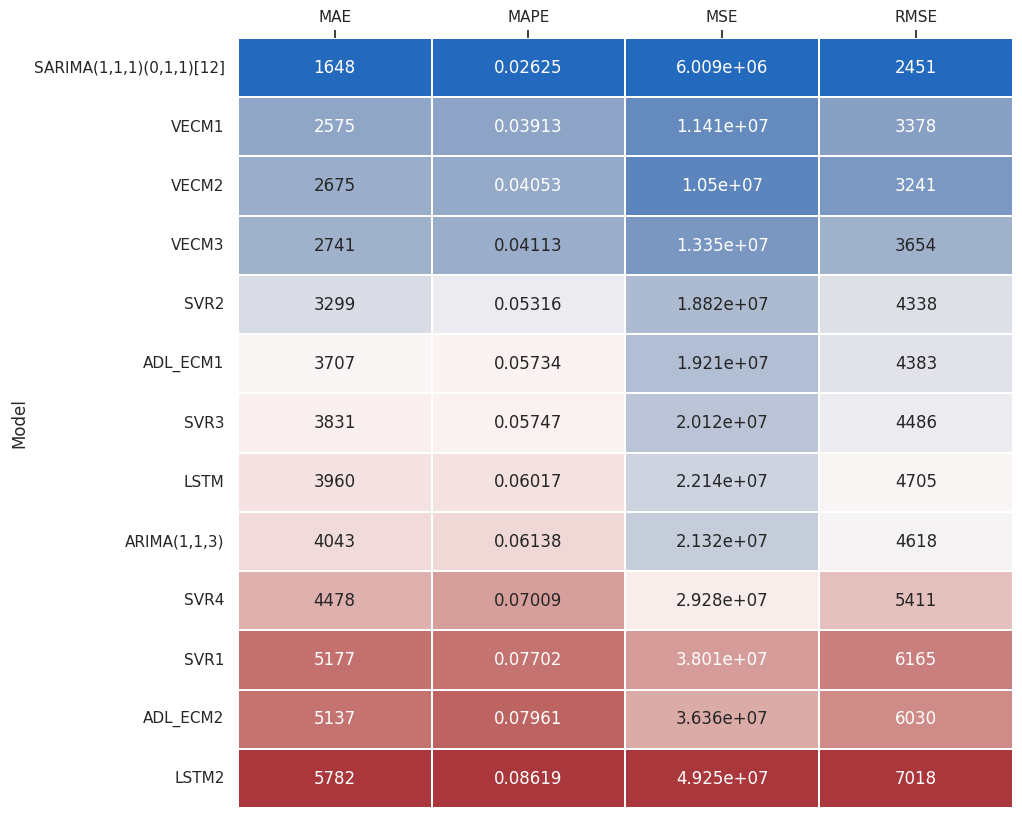

In [ ]:
plt.figure(figsize=(10,10))

norm_df = (medidas - medidas.min(0)) / (medidas.max(0) - medidas.min(0))


ax=sns.heatmap(norm_df.astype(float), annot=medidas, cmap="vlag", cbar=False, lw=0.01,fmt='.4g')
ax.set(xlabel="")#, ylabel="")
ax.xaxis.tick_top()

plt.savefig('Imagens/Comparativo3',bbox_inches='tight')
plt.show()

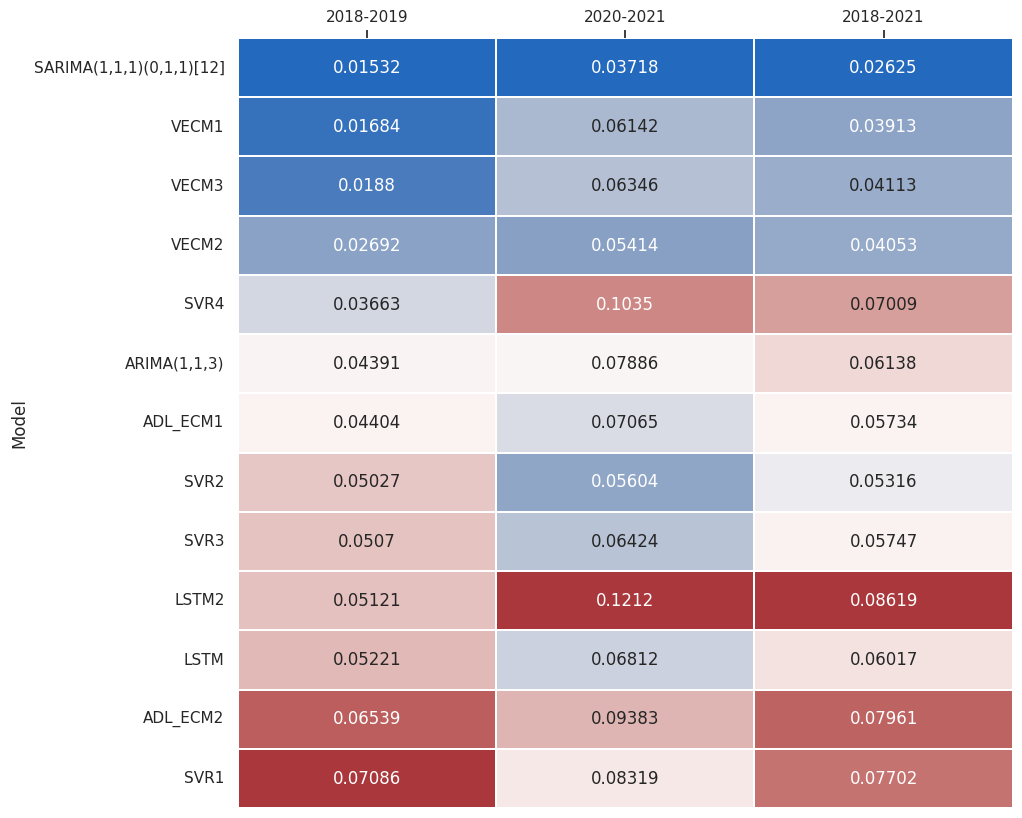

In [ ]:
 plt.figure(figsize=(10,10))
 
norm_df = (MAPE_compare - MAPE_compare.min(0)) / (MAPE_compare.max(0) - MAPE_compare.min(0))

ax=sns.heatmap(norm_df.astype(float), annot=MAPE_compare, cmap="vlag", cbar=False, lw=0.01,fmt='.4g')
ax.xaxis.tick_top()

plt.savefig('Imagens/Comparativo4',bbox_inches='tight')
plt.show()

#boxplot


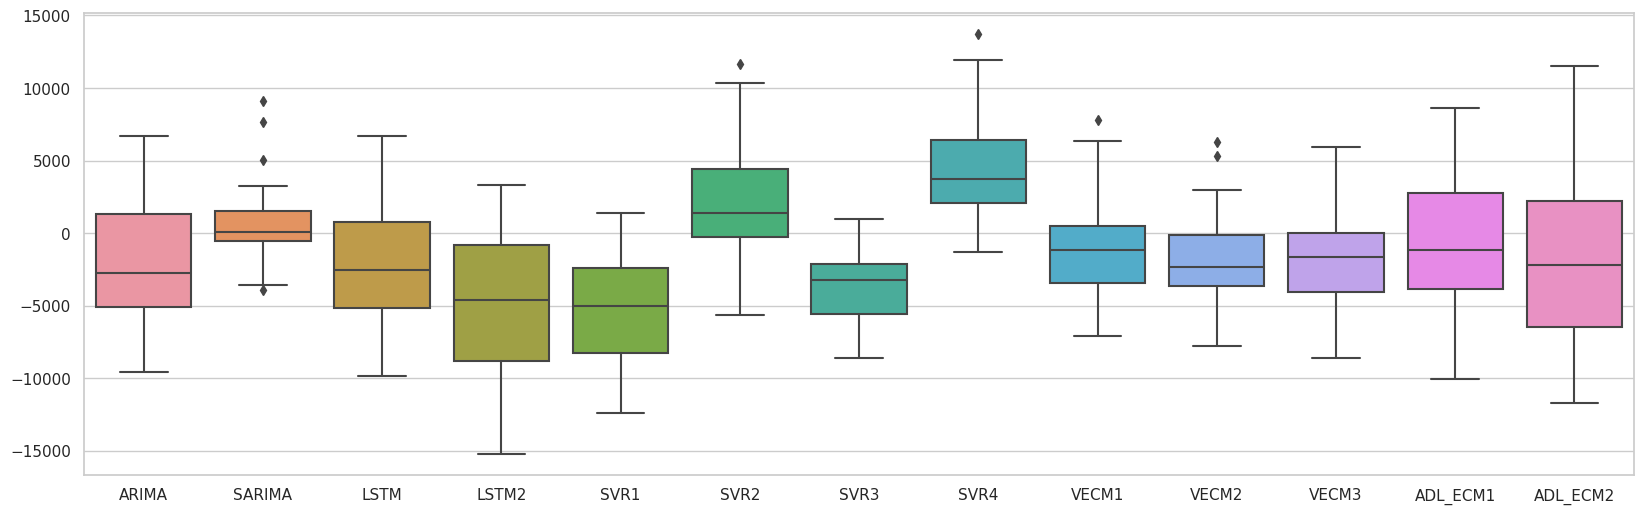

In [ ]:
e_set=pd.DataFrame()

for i in range(len(preds_series)):
  e_set[modelos[i]]=pd.DataFrame(preds_series[i])
  e_set[modelos[i]]=e_set[modelos[i]]-test_set['carga']

for i in range(len(RPreds.columns)):
  RPredst=pd.DataFrame(RPreds[RPreds.columns[i]]-test_set['carga']).rename(columns={0:RPreds.columns[i][6:]})
  e_set=e_set.merge(RPredst,left_index=True,right_index=True)

e_set.rename(columns={'ARIMA(1,1,3)':'ARIMA',
                      'SARIMA(1,1,1)(0,1,1)[12]':'SARIMA'},inplace=True)


# Tamanho do gráfico em polegadas
plt.figure(figsize =(20, 6))

sns.set_style("whitegrid")

ax = sns.boxplot( data = e_set)

plt.savefig('Imagens/boxplot',bbox_inches='tight')

plt.show()

#Exportar tabelas

In [ ]:
tabelas=[accu_meds1,  accu_meds2,  accu_meds3,  accu_meds3f,  accu_meds4,  accu_meds4f,  accu_meds5,  accu_meds6,  accu_meds7,  accu_meds8, 
         carga_head,  cormatrix1,  cormatrix2,  descricao,  df3_head,  dfuller, dfuller_gdp, dfuller_met, 
         gdp_head2,  gdp_head,  met_data_head, met_data_head2]

tabelas_nomes=['accu_meds1',  'accu_meds2',  'accu_meds3',  'accu_meds3f',  'accu_meds4',  'accu_meds4f', 'accu_meds5', 'accu_meds6', 'accu_meds7',
               'accu_meds8', 'carga_head',  'cormatrix1',  'cormatrix2', 'descricao', 'df3_head', 'dfuller','dfuller_gdp','dfuller_met',
               'gdp_head2', 'gdp_head', 'met_data_head',  'met_data_head2']


In [ ]:
j=0

a=0
v=0
m=8

accu_dict={"Model":"Modelo","MAE":0,"MAPE":0,"MSE":0,"RMSE":0}
accu_medsR=pd.DataFrame(accu_dict.keys())
accu_medsR[1]=pd.DataFrame(accu_dict.values())
accu_medsR=accu_medsR.set_index(0).T.set_index('Model')

Rforecasts=os.listdir('Rforecasts')
root_path2=root_path+'/Rforecasts'

with open('tables.tex','w') as file:
  for i in tabelas:
    file.write(tabelas_nomes[j])
    file.write('\n\n')
    file.write(i.to_latex())
    file.write('\n')
    j=j+1

  for i in Rforecasts:
    print(i)
    m=m+1
    g=g+1
    caminho=root_path2+'/'+i
    RPredst=pd.read_csv(caminho)
    RPredst['Ano_Mês']=test_set.index
    RPredst.set_index('Ano_Mês',inplace=True)

    if i[0:3]=='ADL':
      RPredst.rename(columns={'x':'carga'},inplace=True)

    mae = metrics.mean_absolute_error(df3.set_index('Ano_Mês').loc['2018-01-01':]['carga'], RPredst['carga'])
    mape=metrics.mean_absolute_percentage_error(df3.set_index('Ano_Mês').loc['2018-01-01':]['carga'], RPredst['carga'])
    mse = metrics.mean_squared_error(df3.set_index('Ano_Mês').loc['2018-01-01':]['carga'], RPredst['carga'])
    rmse = np.sqrt(mse) # or mse**(0.5)
  
    if i[0:3]=='VAR':
      nome='VECM'+i[8]
    else:
      nome='ADL_ECM'+i[8]
      
    accu_dict={"Model":nome,"MAE":mae,"MAPE":mape,"MSE":mse,"RMSE":rmse}
    accu_medsRt=pd.DataFrame(accu_dict.keys())
    accu_medsRt[1]=pd.DataFrame(accu_dict.values())
    accu_medsRt=accu_medsRt.set_index(0).T.set_index('Model')
    
    file.write('accu_meds'+str(m))
    file.write('\n\n')
    file.write(accu_medsRt.to_latex())
    file.write('\n')


<ipython-input-101-f6af3f25aaaa>:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  file.write(i.to_latex())
<ipython-input-101-f6af3f25aaaa>:52: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  file.write(accu_medsRt.to_latex())


VARpreds1.csv
VARpreds2.csv
VARpreds3.csv
ADLpreds1.csv
ADLpreds2.csv


<ipython-input-101-f6af3f25aaaa>:52: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  file.write(accu_medsRt.to_latex())
<ipython-input-101-f6af3f25aaaa>:52: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  file.write(accu_medsRt.to_latex())
<ipython-input-101-f6af3f25aaaa>:52: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is 